# kNN
* kNN - распознавание растровых изображений
* kNN- и ODIN-идентификаторы 

In [661]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Функции расстояния между точками
Евклидово расстояние

In [662]:
def euc_dist(x, y):
    return np.sqrt(np.sum((x-y)**2))

Квадрат Евклидова расстояния

In [663]:
def euc_dist_sqr(x, y):
    return np.sum((x-y)**2)

Модульное расстояние

In [664]:
def abs_dist(x, y):
    return np.sum((np.abs(x-y)))

Расстояние Чебышева

In [665]:
def cheb_dist(x, y):
    return np.max((np.abs(x-y)))

### Реализация kNN

Для каждого объекта из тестовой выборки считаем расстояние до всех объектов в обучающей выборке. Выбираем k ближайших и вычисляем вектор вероятностей принадлежности объекта к каждому из классов в разметке.

In [666]:
class KNN:
    def __init__(self, k=3):
        self.y_train = None
        self.x_train = None
        self.k = k
        
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        
    def predict(self, x_test, dist_func):
        predictions = []
        for i in range(len(x_test)):
            dist = np.array([dist_func(x_test[i], x_t) for x_t in self.x_train])
            dist_sorted = dist.argsort()[:self.k]
            neigh_count = [0] * 10
            
            for idx in dist_sorted:
                neigh_count[self.y_train[idx]] += 1
                
            neigh_probs = [0] * 10
            for j in range(0, 10):
                neigh_probs[j] = neigh_count[j] / self.k
                
            pred_arg = neigh_probs
            max_index = np.argmax(neigh_probs)
            index = 0
            while index < len(pred_arg):
                if index != max_index:
                    pred_arg[index] = 0
                else:
                    pred_arg[index] = 1
                index += 1
                
            predictions.append(max_index)
        return predictions

### Импорт данных MNIST

In [667]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

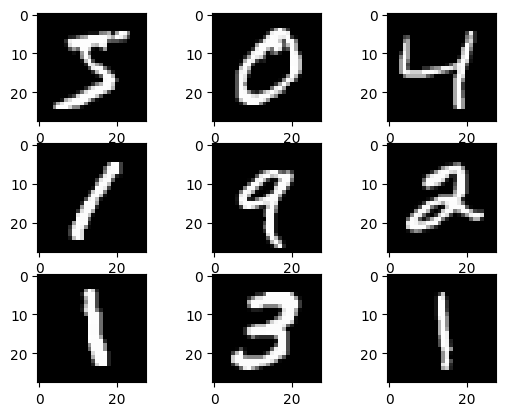

In [668]:
from matplotlib import pyplot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

### Бинаризация данных

In [669]:
def to_bw(image):
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if image[i][j] != 0:
                image[i][j] = 1

In [670]:
(X_train_bw, y_train_bw), (X_test_bw, y_test_bw) = mnist.load_data()

for i in range(0, X_train_bw.shape[0]):
    to_bw(X_train_bw[i])
    
for i in range(0, X_test_bw.shape[0]):
    to_bw(X_test_bw[i])

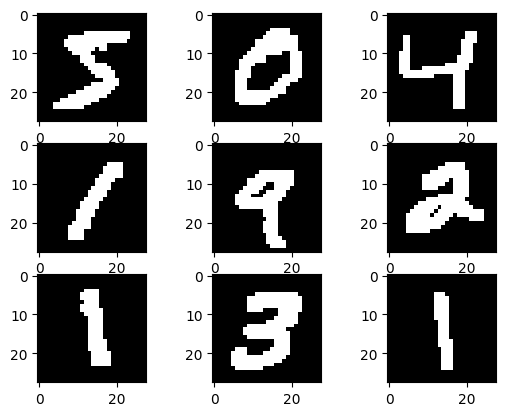

In [671]:
from matplotlib import pyplot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train_bw[i], cmap=pyplot.get_cmap('gray'))
pyplot.show();

### Преобразование данных
Преобразование картинок в одномерные массивы пикселей
База данных MNIST содержит 60000 для обучения изображений размером 28 на 28 пикселей

In [672]:
X_train = X_train.reshape(60000, 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

X_train_bw = X_train_bw.reshape(60000, 28 * 28)
X_test_bw = X_test_bw.reshape(X_test_bw.shape[0], 28 * 28)

X_train.shape

(60000, 784)

In [673]:
from matplotlib import pyplot as plt

### Функция обучения по картинкам

In [678]:
def predict_on_images(X_train, y_train, X_test, y_test, dist_func, klimit):
    k_values = np.arange(1, klimit)
    
    for k in k_values:
        model = KNN(k = k)
        model.fit(X_train, y_train)
        pred = model.predict(X_test, dist_func)
        
        if k == 1 or k == 5 or k == 30:
            print('Confusion Matrix for dist:' + str(dist_func.__name__) + ' with k = ' + str(k))
            cm = confusion_matrix(y_test, pred, )
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
            disp.plot(cmap='magma')
            plt.show()
            print('Accuracy: {}%'.format(accuracy_score(y_test, pred) * 100))
            print('\n')

In [679]:
train_start = 0
train_limit = 5000
test_limit = 100
klimit = 31

In [680]:
def predict_with_different_dist(x_train_curr, y_train_curr, x_test_curr, y_test_curr):
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        euc_dist,
        klimit
    )
    
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        euc_dist_sqr,
        klimit
    )
    
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        abs_dist,
        klimit
    )
    
    predict_on_images(
        x_train_curr[train_start:train_limit],
        y_train_curr[train_start:train_limit],
        x_test_curr[0:test_limit],
        y_test_curr[0:test_limit],
        cheb_dist,
        klimit
    )
    

Предсказание модели для градаций серого

Confusion Matrix for dist:euc_dist with k = 1


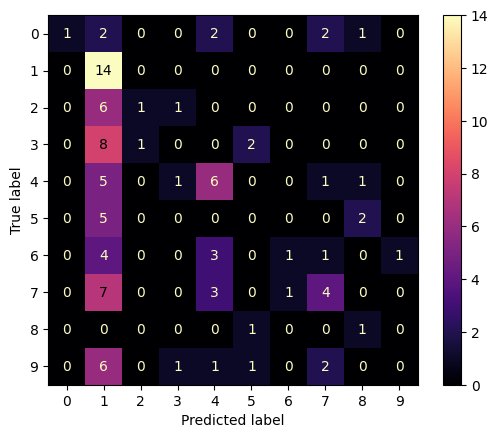

Accuracy: 28.000000000000004%

Confusion Matrix for dist:euc_dist with k = 5


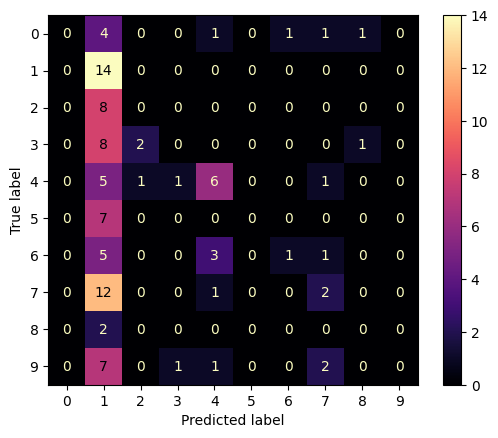

Accuracy: 23.0%

Confusion Matrix for dist:euc_dist with k = 30


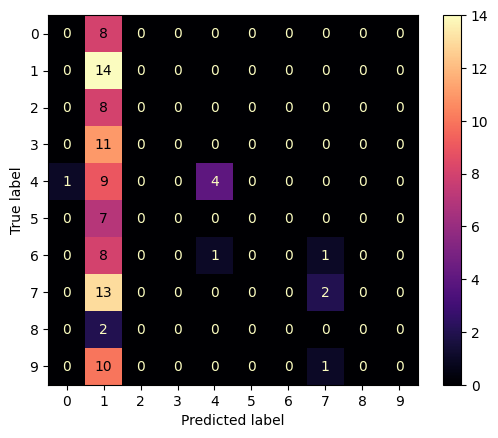

Accuracy: 20.0%

Confusion Matrix for dist:euc_dist_sqr with k = 1


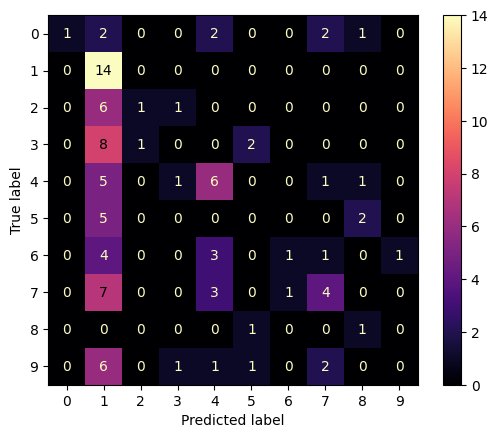

Accuracy: 28.000000000000004%

Confusion Matrix for dist:euc_dist_sqr with k = 5


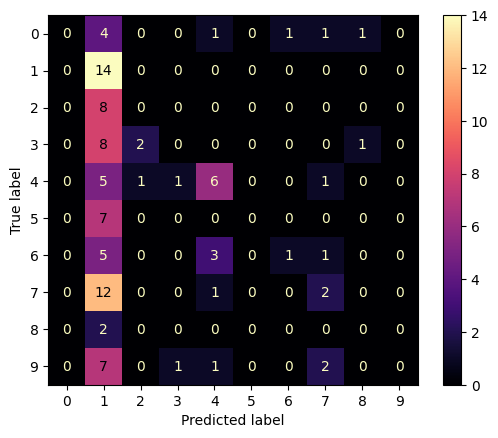

Accuracy: 23.0%

Confusion Matrix for dist:euc_dist_sqr with k = 30


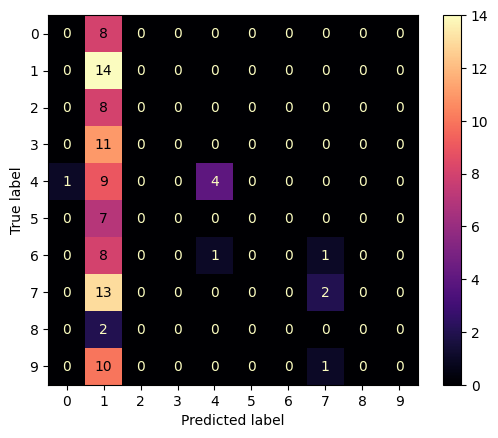

Accuracy: 20.0%

Confusion Matrix for dist:abs_dist with k = 1


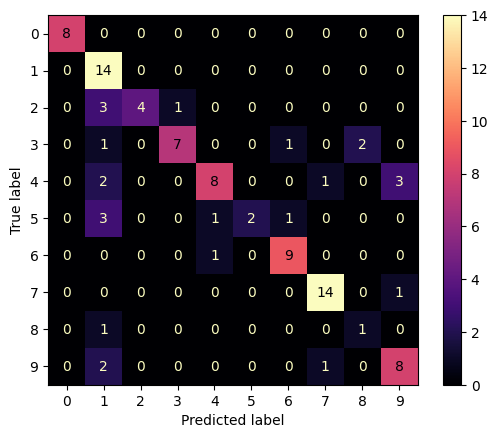

Accuracy: 75.0%

Confusion Matrix for dist:abs_dist with k = 5


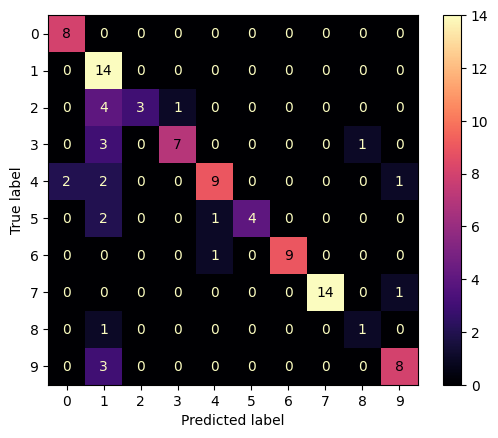

Accuracy: 77.0%

Confusion Matrix for dist:abs_dist with k = 30


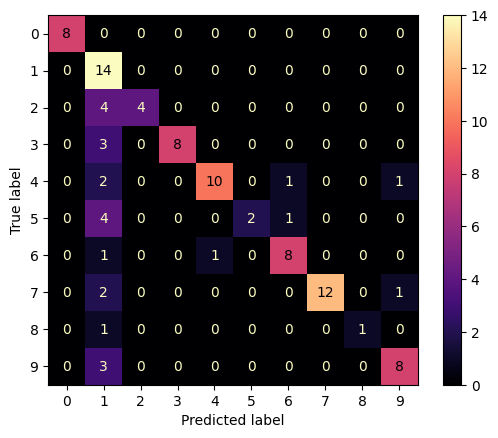

Accuracy: 75.0%

Confusion Matrix for dist:cheb_dist with k = 1


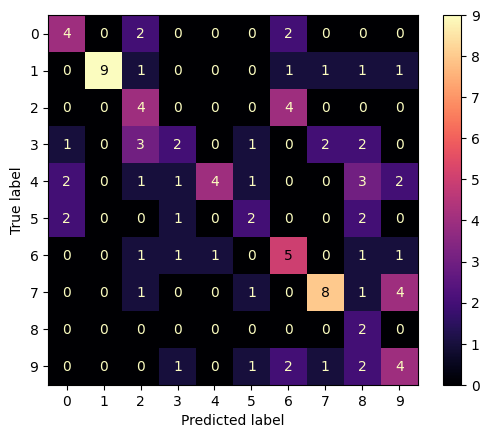

Accuracy: 44.0%

Confusion Matrix for dist:cheb_dist with k = 5


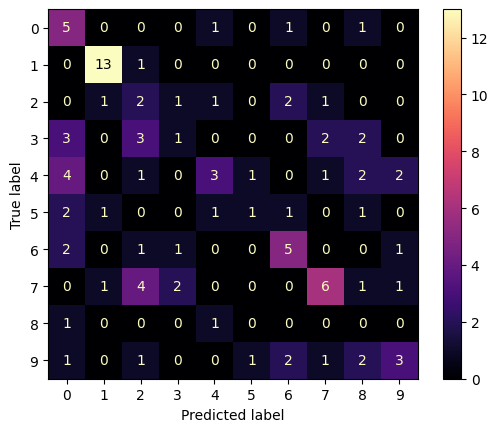

Accuracy: 39.0%

Confusion Matrix for dist:cheb_dist with k = 30


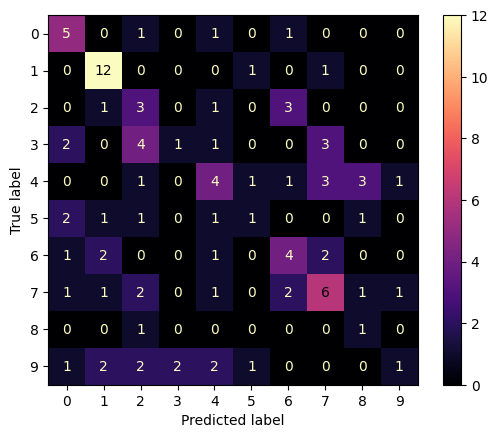

Accuracy: 38.0%



In [681]:
predict_with_different_dist(X_train, y_train, X_test, y_test)

Предсказания для Ч\Б изображений

Confusion Matrix for dist:euc_dist with k = 1


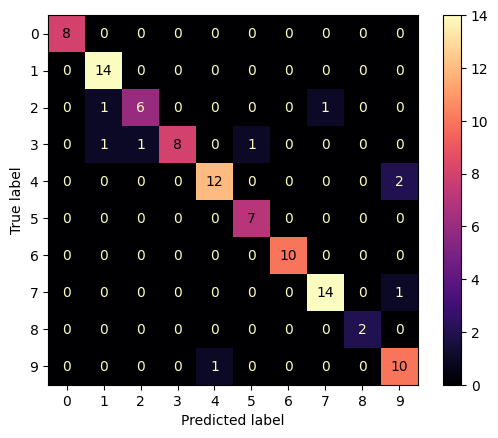

Accuracy: 91.0%

Confusion Matrix for dist:euc_dist with k = 5


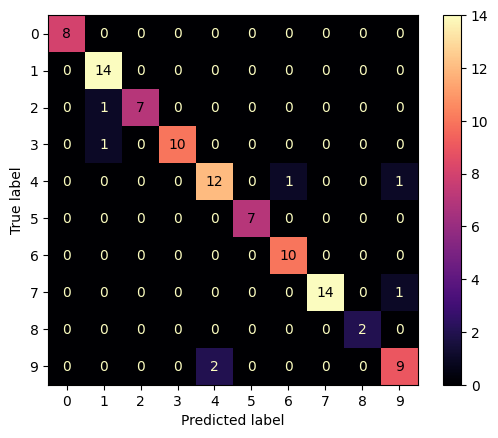

Accuracy: 93.0%

Confusion Matrix for dist:euc_dist with k = 30


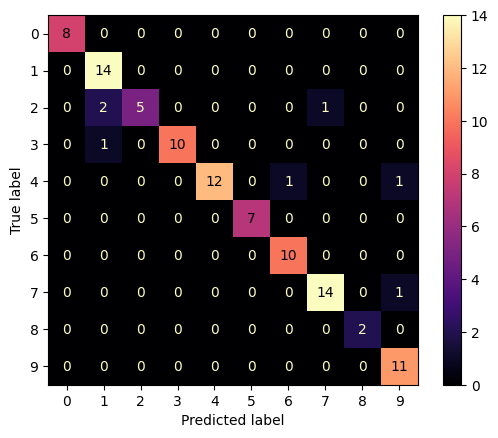

Accuracy: 93.0%

Confusion Matrix for dist:euc_dist_sqr with k = 1


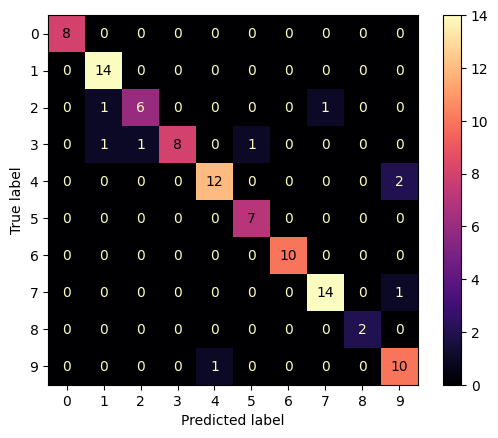

Accuracy: 91.0%

Confusion Matrix for dist:euc_dist_sqr with k = 5


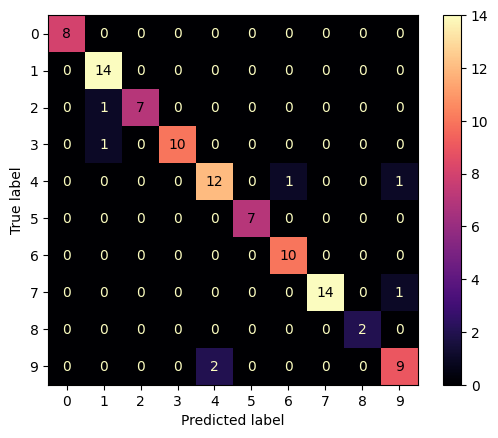

Accuracy: 93.0%

Confusion Matrix for dist:euc_dist_sqr with k = 30


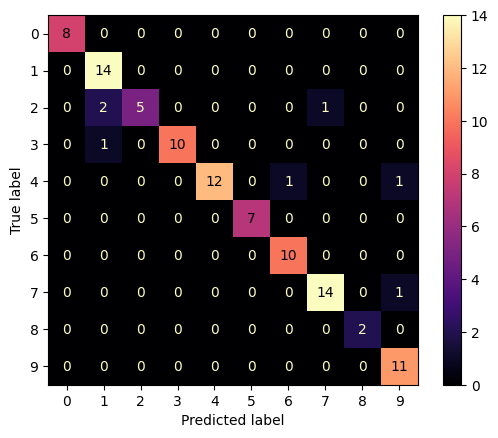

Accuracy: 93.0%

Confusion Matrix for dist:abs_dist with k = 1


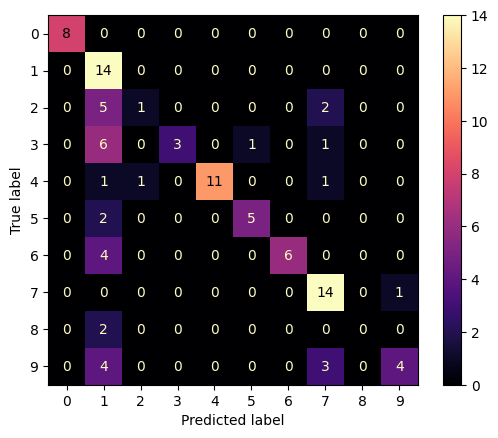

Accuracy: 66.0%

Confusion Matrix for dist:abs_dist with k = 5


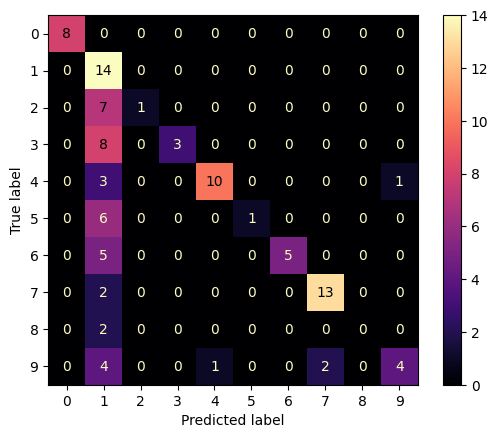

Accuracy: 59.0%

Confusion Matrix for dist:abs_dist with k = 30


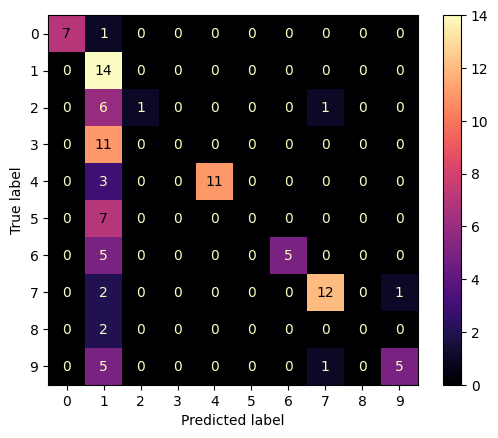

Accuracy: 55.00000000000001%

Confusion Matrix for dist:cheb_dist with k = 1


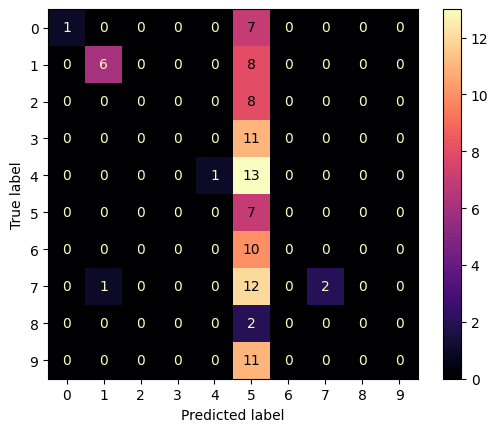

Accuracy: 17.0%

Confusion Matrix for dist:cheb_dist with k = 5


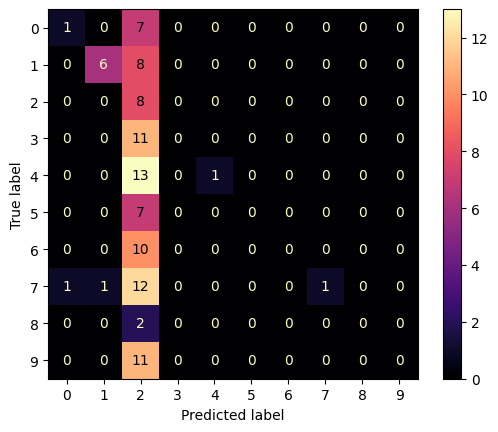

Accuracy: 17.0%

Confusion Matrix for dist:cheb_dist with k = 30


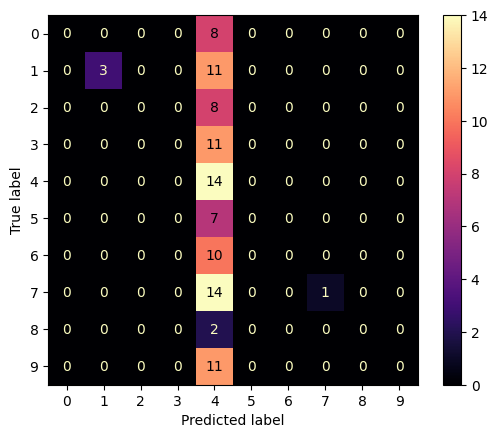

Accuracy: 18.0%



In [682]:
predict_with_different_dist(X_train_bw, y_train_bw, X_test_bw, y_test_bw)

In [683]:
import random

### Зашумление данных

In [684]:
def gray_noise(pixel):
    result = random.randint(0, 255)
    while result == pixel:
        result = random.randint(0, 255)
    return result

def bw_noise(pixel):
    if pixel == 0:
        return 1
    else:
        return 0

Зашумление картинки либо полностью, либо частично. Также можем зашумлять область со случайным центром и радиусом. Вероятность зашумления пикселя задается вручную в параметре функции.

In [685]:
def noise_image(image, probability, func):
    for x in range(image.shape[0]):
      if random.random() < probability:
        image[x] = func(image[x])


def noise_image_area(image, center, radius, probability, func):
    x_start = 0
    y_start = 0
    x_finish = 28
    y_finish = 28
    
    if center[0] - radius > 0:
        x_start = center[0] - radius
    if center[1] - radius > 0:
        y_start = center[1] - radius
    if center[0] + radius < 28:
        x_finish = center[0] + radius
    if center[1] + radius < 28:
        y_finish = center[1] + radius

    for x in range(x_start, x_finish):
        for y in range(y_start, y_finish):
            if random.random() < probability:
                image[x * 28 + y] = func(x * 28 + y)


def noise_images(images, prob, noise_func):
  for i in range(0, images.shape[0]):
    noise_image(images[i], prob, noise_func)


def noise_images_area(images, prob, noise_func):
  for i in range(0, images.shape[0]):
    noise_image_area(images[i], (random.randint(0, 27), random.randint(0, 27)), random.randint(2, 7), prob, noise_func)

  
def show_images(images):
  images = images.copy().reshape(len(images), 28, 28)
  from matplotlib import pyplot
  for i in range(min(9, len(images))):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(images[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [686]:
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train_bw_orig = X_train_bw.copy()
X_test_bw_orig = X_test_bw.copy()

Равномерное зашумление градаций серого

In [687]:
noise_images(X_train, 0.3, gray_noise)
noise_images(X_test, 0.3, gray_noise)

Равномреное зашумление Ч/Б

In [688]:
noise_images(X_train_bw, 0.3, bw_noise)
noise_images(X_test_bw, 0.3, bw_noise)

Примеры равномерно зашумленных изображений

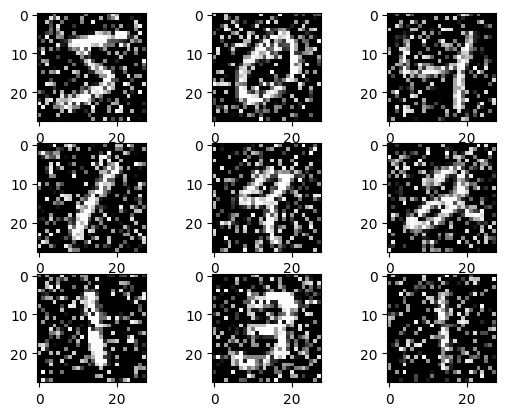

In [689]:
show_images(X_train)

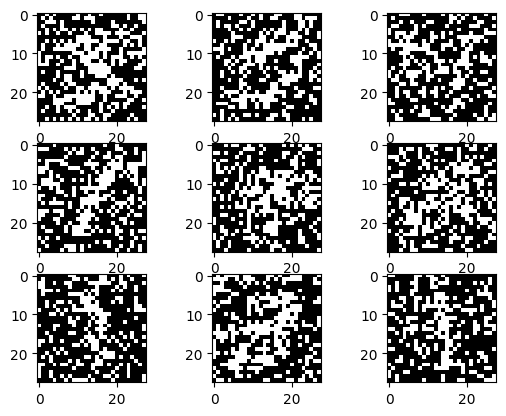

In [690]:
show_images(X_train_bw)

Предсказание для равномерно зашумленных градаций серого

Confusion Matrix for dist:euc_dist with k = 1


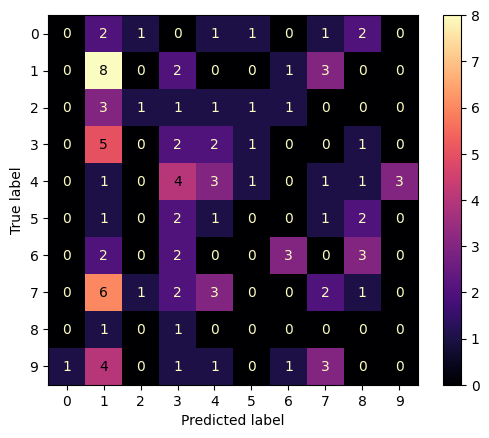

Accuracy: 19.0%

Confusion Matrix for dist:euc_dist with k = 5


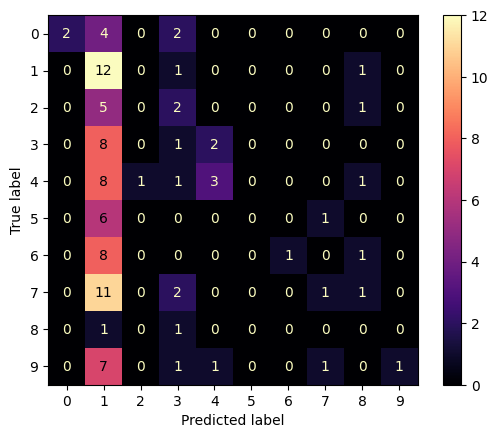

Accuracy: 21.0%

Confusion Matrix for dist:euc_dist with k = 30


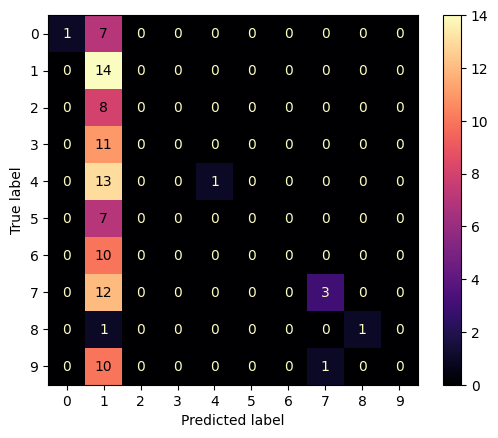

Accuracy: 20.0%

Confusion Matrix for dist:euc_dist_sqr with k = 1


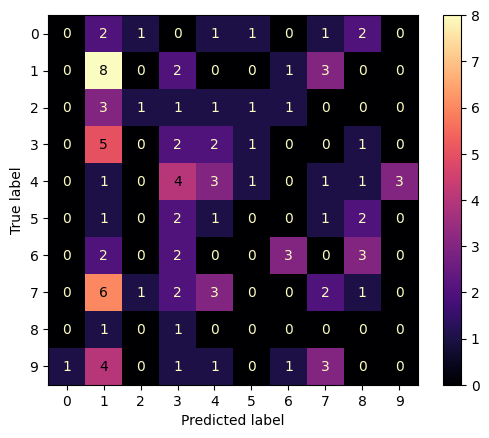

Accuracy: 19.0%

Confusion Matrix for dist:euc_dist_sqr with k = 5


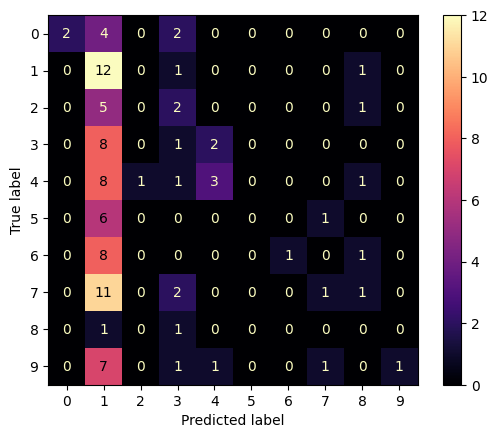

Accuracy: 21.0%

Confusion Matrix for dist:euc_dist_sqr with k = 30


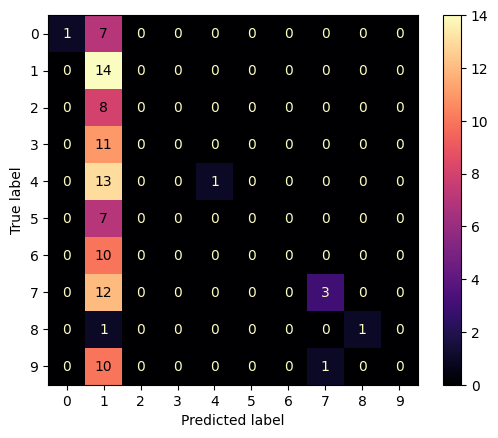

Accuracy: 20.0%

Confusion Matrix for dist:abs_dist with k = 1


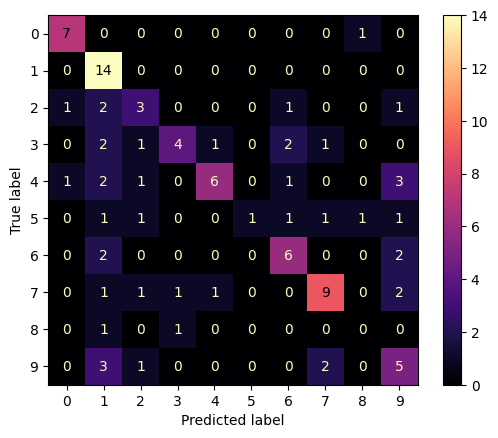

Accuracy: 55.00000000000001%

Confusion Matrix for dist:abs_dist with k = 5


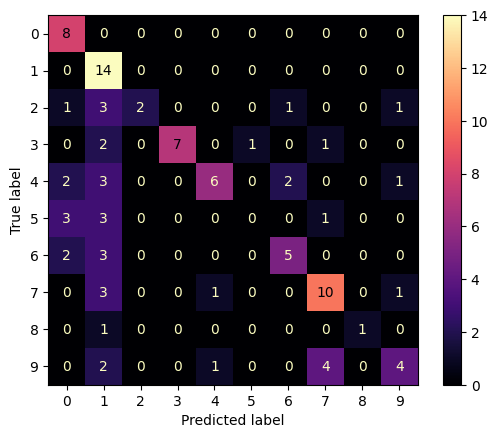

Accuracy: 56.99999999999999%

Confusion Matrix for dist:abs_dist with k = 30


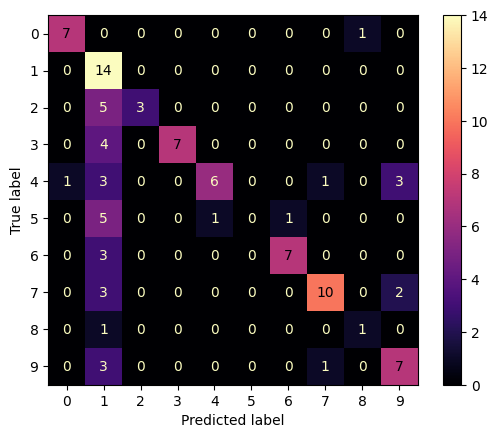

Accuracy: 62.0%

Confusion Matrix for dist:cheb_dist with k = 1


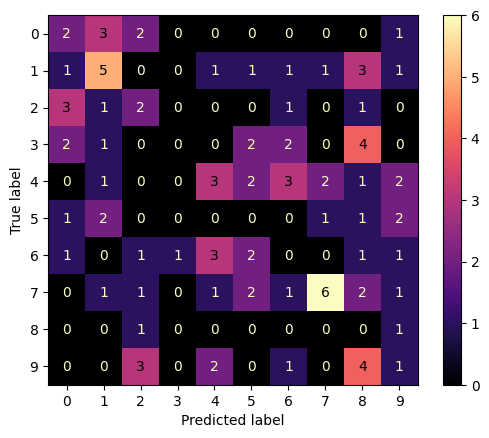

Accuracy: 19.0%

Confusion Matrix for dist:cheb_dist with k = 5


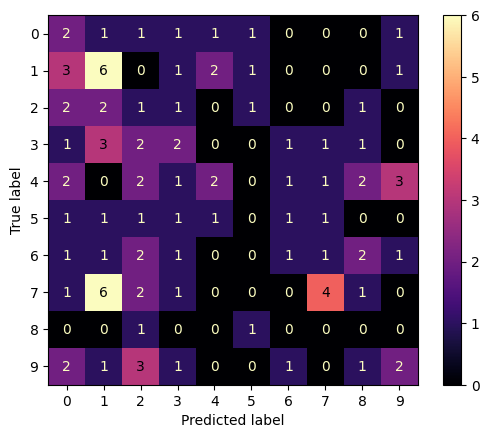

Accuracy: 20.0%

Confusion Matrix for dist:cheb_dist with k = 30


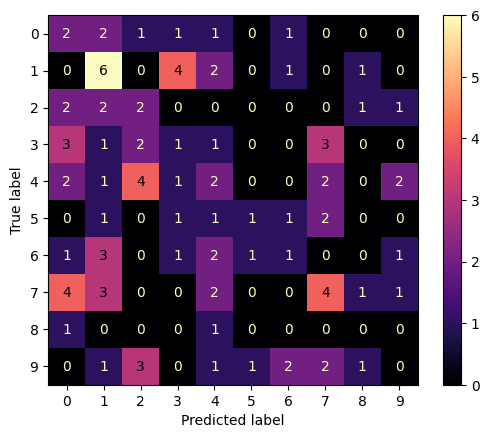

Accuracy: 19.0%



In [691]:
predict_with_different_dist(X_train, y_train, X_test, y_test)

Предсказание для равномерно зашумленных Ч/Б изображений

Confusion Matrix for dist:euc_dist with k = 1


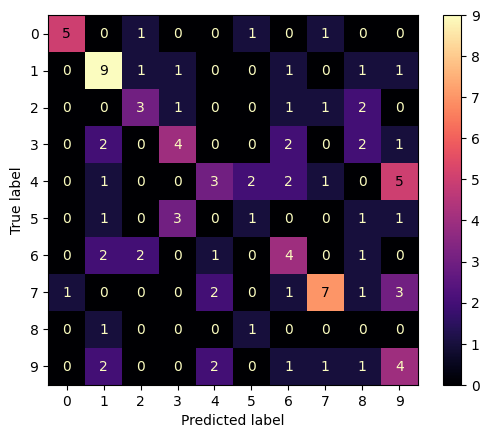

Accuracy: 40.0%

Confusion Matrix for dist:euc_dist with k = 5


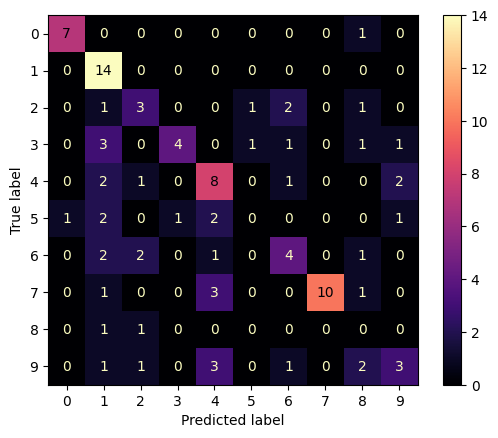

Accuracy: 53.0%

Confusion Matrix for dist:euc_dist with k = 30


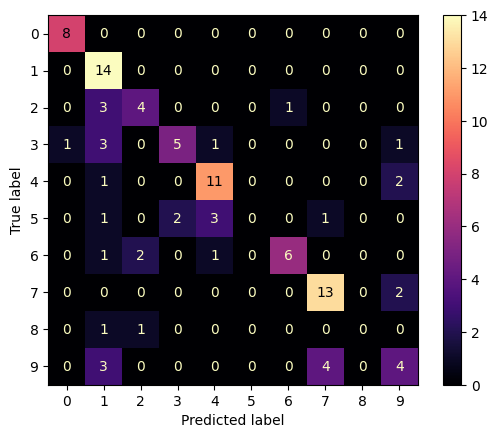

Accuracy: 65.0%

Confusion Matrix for dist:euc_dist_sqr with k = 1


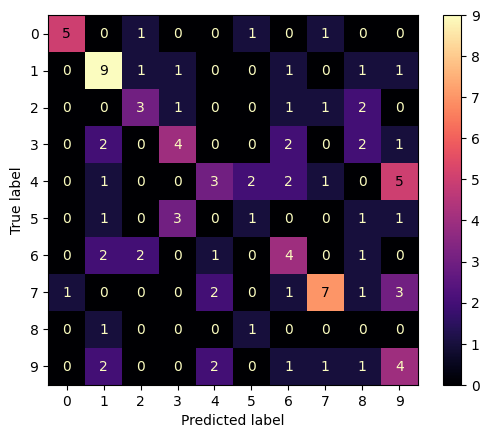

Accuracy: 40.0%

Confusion Matrix for dist:euc_dist_sqr with k = 5


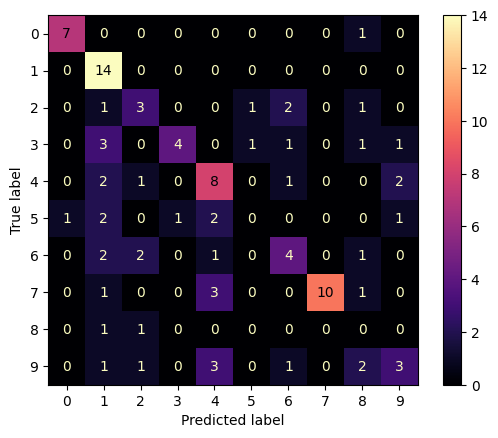

Accuracy: 53.0%

Confusion Matrix for dist:euc_dist_sqr with k = 30


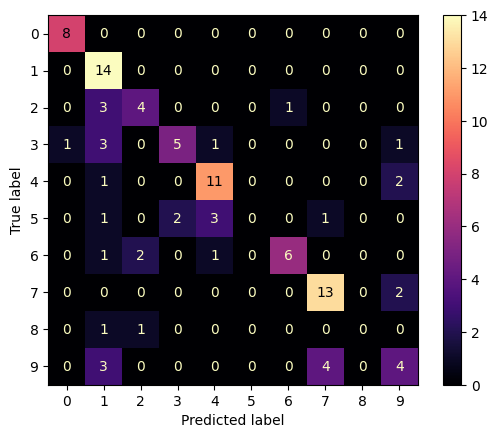

Accuracy: 65.0%

Confusion Matrix for dist:abs_dist with k = 1


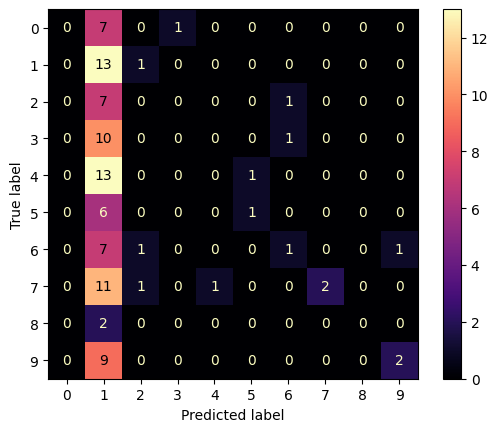

Accuracy: 19.0%

Confusion Matrix for dist:abs_dist with k = 5


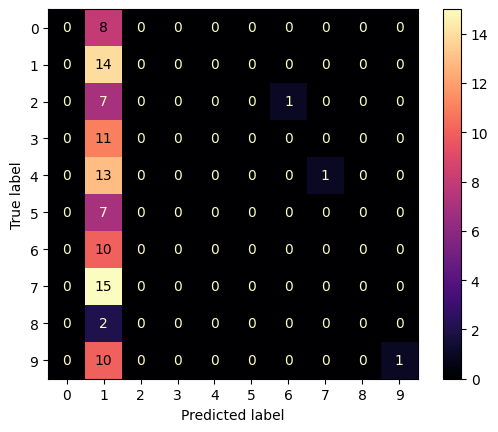

Accuracy: 15.0%

Confusion Matrix for dist:abs_dist with k = 30


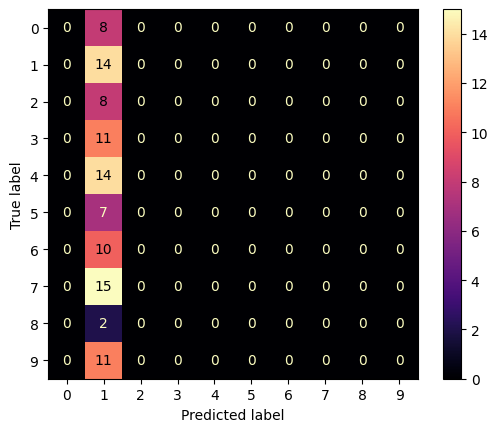

Accuracy: 14.000000000000002%

Confusion Matrix for dist:cheb_dist with k = 1


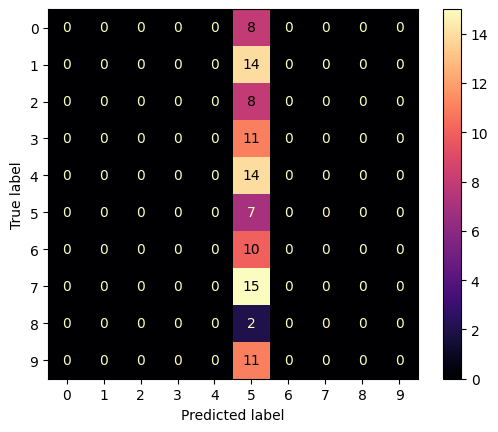

Accuracy: 7.000000000000001%

Confusion Matrix for dist:cheb_dist with k = 5


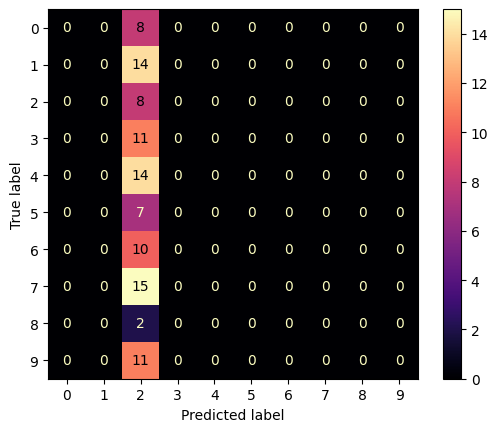

Accuracy: 8.0%

Confusion Matrix for dist:cheb_dist with k = 30


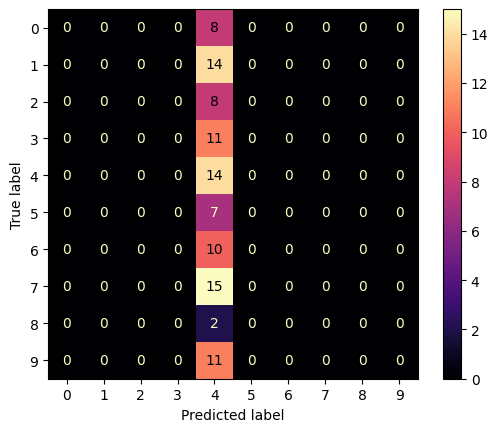

Accuracy: 14.000000000000002%


In [692]:
predict_with_different_dist(X_train_bw, y_train_bw, X_test_bw, y_test_bw)

In [693]:
X_train = X_train_orig.copy()
X_test = X_test_orig.copy()

X_train_bw = X_train_bw_orig.copy()
X_test_bw = X_test_bw_orig.copy()

Неравномерное зашумление градаций серого

In [694]:
noise_images_area(X_train, 0.3, gray_noise)
noise_images_area(X_test, 0.3, gray_noise)

Неравномерное зашумление Ч/Б

In [695]:
noise_images_area(X_train_bw, 0.3, bw_noise)
noise_images_area(X_test_bw, 0.3, bw_noise)

Примеры неравномерно зашумленных изображений

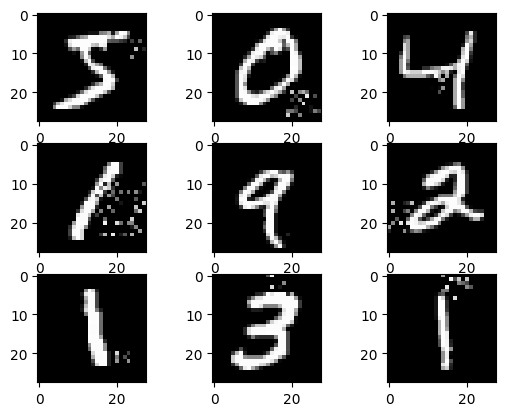

In [696]:
show_images(X_train)

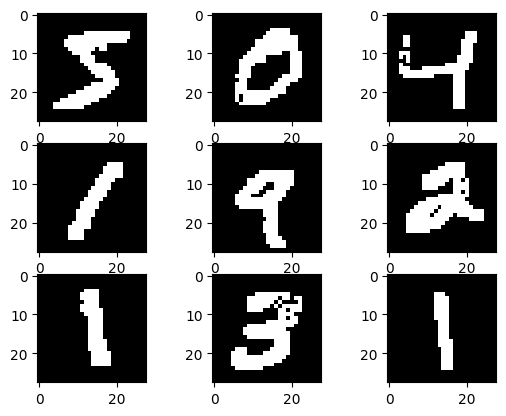

In [697]:
show_images(X_train_bw)

Предсказания для неравномерно зашумленных градаций серого

Confusion Matrix for dist:euc_dist with k = 1


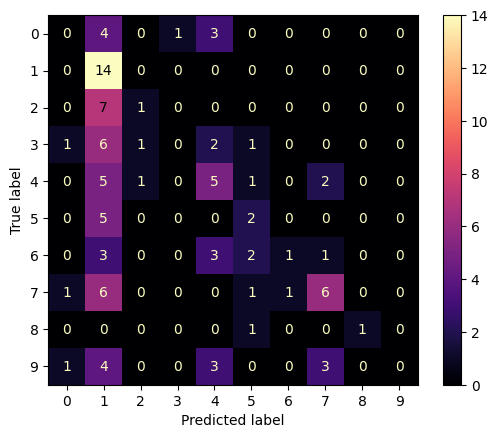

Accuracy: 30.0%

Confusion Matrix for dist:euc_dist with k = 5


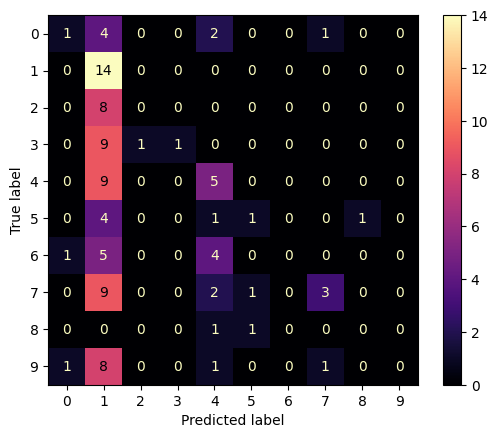

Accuracy: 25.0%

Confusion Matrix for dist:euc_dist with k = 30


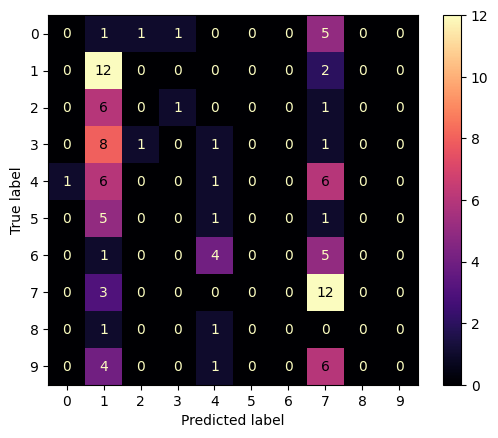

Accuracy: 25.0%

Confusion Matrix for dist:euc_dist_sqr with k = 1


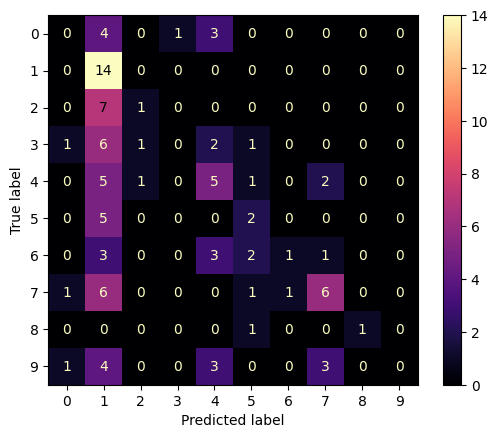

Accuracy: 30.0%

Confusion Matrix for dist:euc_dist_sqr with k = 5


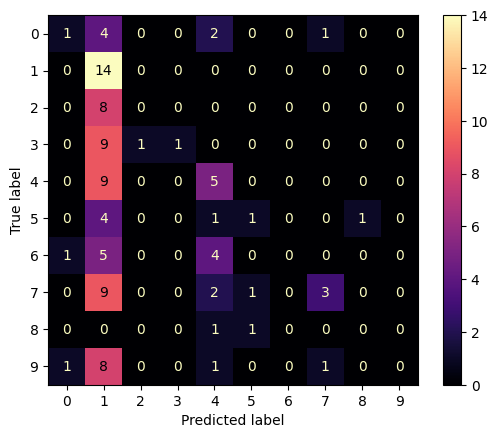

Accuracy: 25.0%

Confusion Matrix for dist:euc_dist_sqr with k = 30


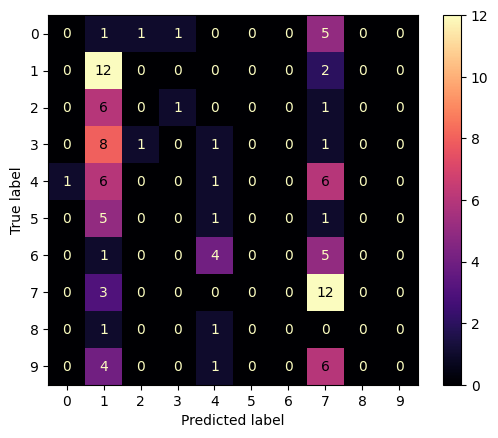

Accuracy: 25.0%

Confusion Matrix for dist:abs_dist with k = 1


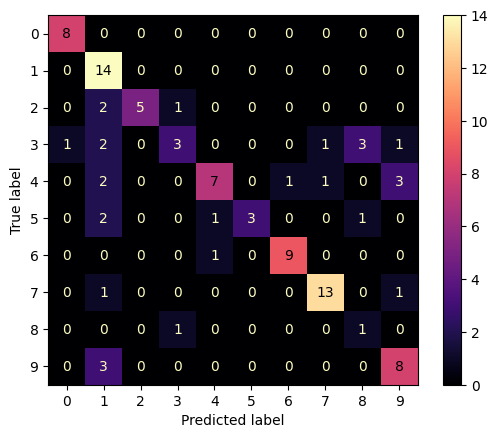

Accuracy: 71.0%

Confusion Matrix for dist:abs_dist with k = 5


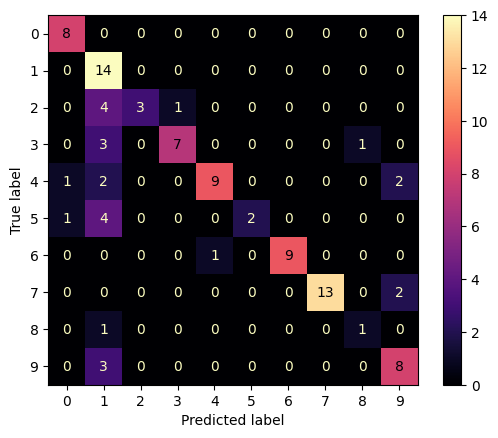

Accuracy: 74.0%

Confusion Matrix for dist:abs_dist with k = 30


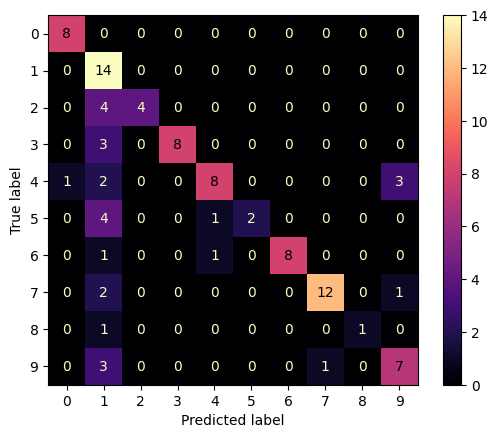

Accuracy: 72.0%

Confusion Matrix for dist:cheb_dist with k = 1


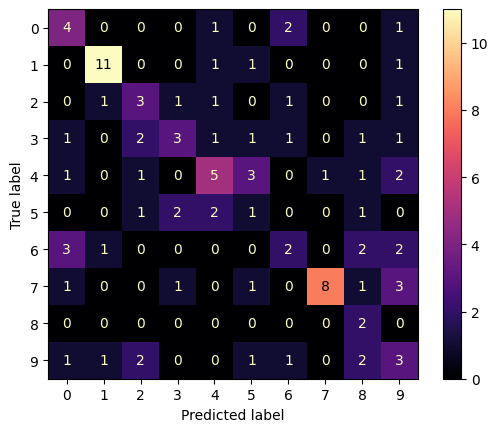

Accuracy: 42.0%

Confusion Matrix for dist:cheb_dist with k = 5


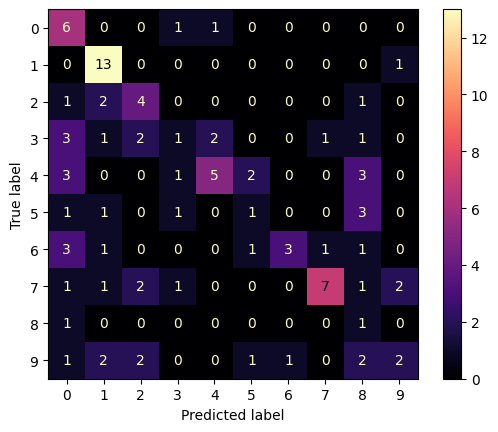

Accuracy: 43.0%

Confusion Matrix for dist:cheb_dist with k = 30


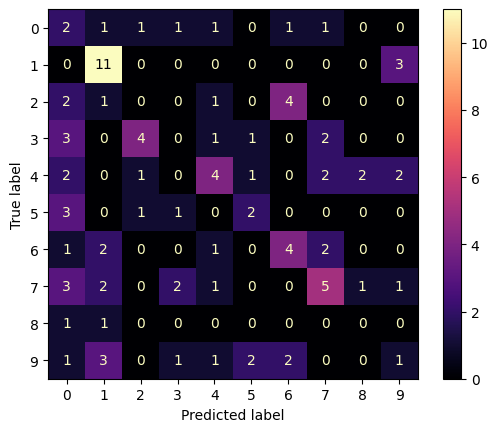

Accuracy: 28.999999999999996%



In [698]:
predict_with_different_dist(X_train, y_train, X_test, y_test)

Предсказания для неравномерно зашумленных Ч/Б

Confusion Matrix for dist:euc_dist with k = 1


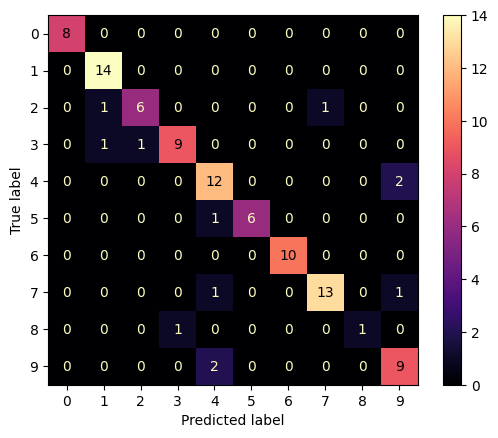

Accuracy: 88.0%

Confusion Matrix for dist:euc_dist with k = 5


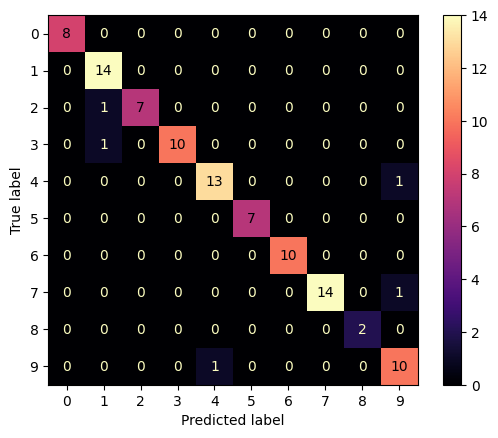

Accuracy: 95.0%

Confusion Matrix for dist:euc_dist with k = 30


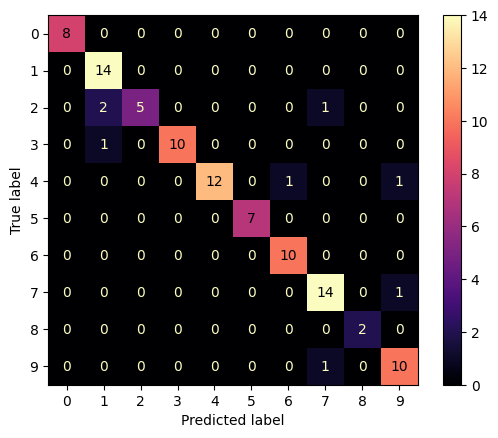

Accuracy: 92.0%

Confusion Matrix for dist:euc_dist_sqr with k = 1


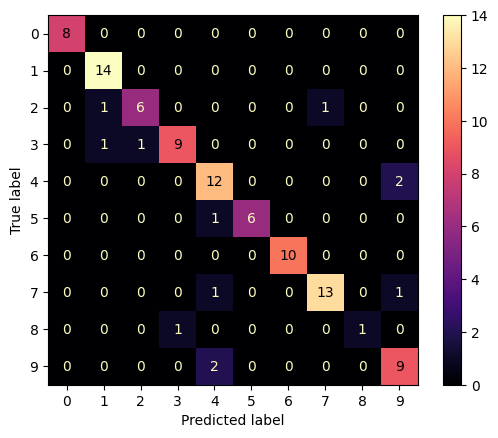

Accuracy: 88.0%

Confusion Matrix for dist:euc_dist_sqr with k = 5


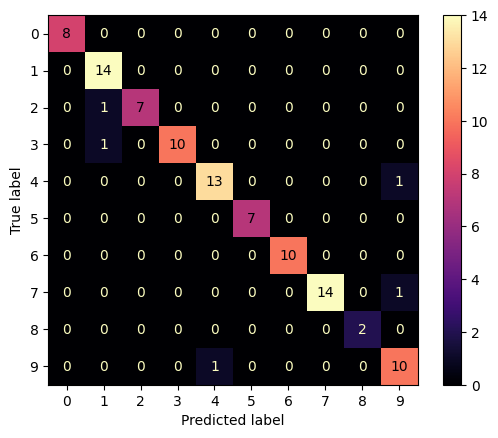

Accuracy: 95.0%

Confusion Matrix for dist:euc_dist_sqr with k = 30


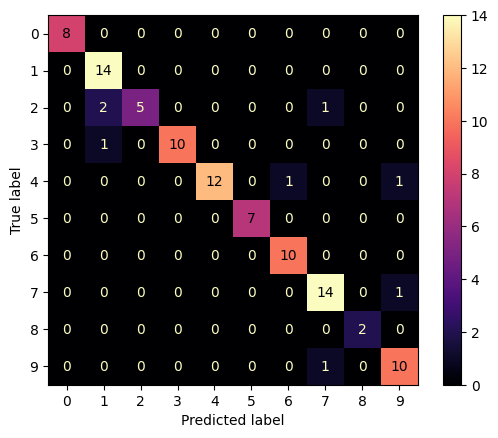

Accuracy: 92.0%

Confusion Matrix for dist:abs_dist with k = 1


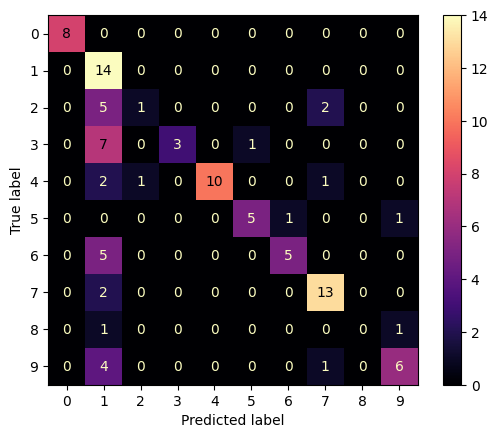

Accuracy: 65.0%

Confusion Matrix for dist:abs_dist with k = 5


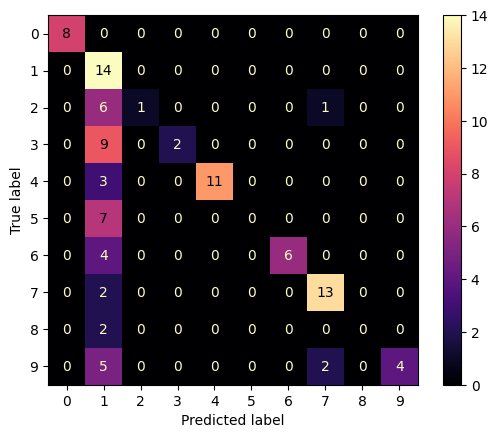

Accuracy: 59.0%

Confusion Matrix for dist:abs_dist with k = 30


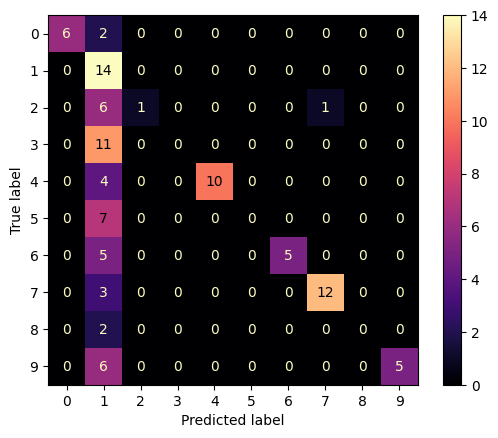

Accuracy: 53.0%

Confusion Matrix for dist:cheb_dist with k = 1


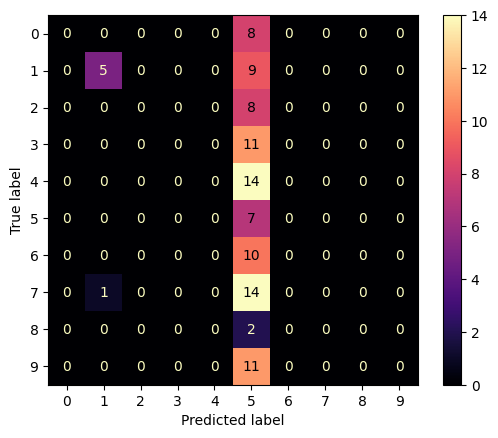

Accuracy: 12.0%

Confusion Matrix for dist:cheb_dist with k = 5


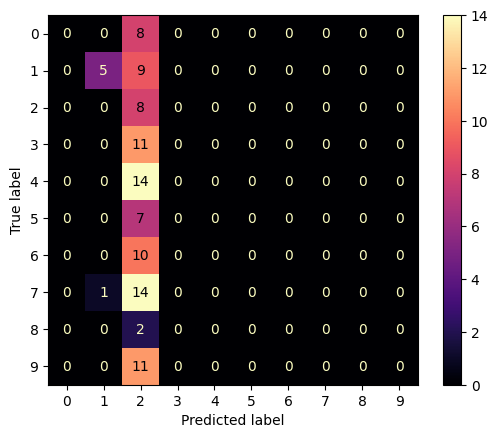

Accuracy: 13.0%

Confusion Matrix for dist:cheb_dist with k = 30


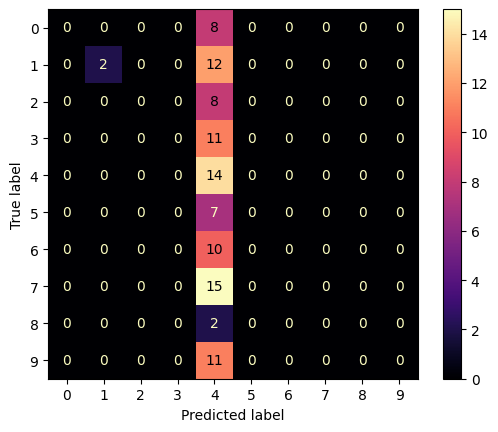

Accuracy: 16.0%



In [699]:
predict_with_different_dist(X_train_bw, y_train_bw, X_test_bw, y_test_bw)

## kNN- и ODIN- идентификаторы

In [700]:
X_train_orig.shape

(60000, 784)

In [701]:
X_train_bw_orig.shape

(60000, 784)

In [702]:
def find_avg_knn_distance(images, distf, k_value):
    all_distances = []
    
    for img in images:
      tmp_list = images.copy()
      tmp_list.remove(img)
      tmp_list.sort(key=lambda img1: distf(np.array(img), np.array(img1))) 
      dists = [tmp_list[:k_value]]
      all_distances.append(dists)
    
    result = np.mean(all_distances)
    print("Среднее расстояние kNN при k = " + str(k_value) + ": " + str(result))
    
    return result

In [703]:
def knn(images, distf, outcasts, k_value):
    result = 0
    
    mean_knn_dist = find_avg_knn_distance(images, distf, k_value)
    
    for img in images:
      tmp_list = images.copy()
      tmp_list.remove(img)
      tmp_list.sort(key=lambda img1: distf(np.array(img), np.array(img1))) 
      dists = [tmp_list[:k_value]]

      if np.mean(dists) > mean_knn_dist:
          outcasts.append(img)
          result += 1
    
    print("Число выбросов, определенных kNN:" + str(result))
    print("Реально выбросов:" + str(len(images)))

In [704]:
def odin(images, distf, outcasts, limit=4, num_occurences=1):
  candidates = []
  
  for img in images:
    tmp_list = images.copy()
    tmp_list.remove(img)
    tmp_list.sort(key=lambda img1: distf(np.array(img), np.array(img1)))
    candidates.append(tmp_list[:limit])
    
    merged_candidates = []
    for img_list in candidates:
      for img in img_list:
        merged_candidates.append(img)
    
  result = 0
  for img in images:
    if merged_candidates.count(img) <= num_occurences:
      outcasts.append(img)
      result += 1
  
  print("Число выбросов, определенных ODIN:" + str(result))
  print("Реально выбросов:" + str(len(images)))

In [705]:
def show_images_outliers(images):
  images = images.copy().reshape(len(images), 28, 28)
  from matplotlib import pyplot
  pyplot.subplots(figsize=(28, 28))
  for i in range(min(len(images), 16*6)):
    pyplot.subplot(16, 6, 1 + i)
    pyplot.imshow(images[i], cmap=pyplot.get_cmap('gray'), vmin=0, vmax=255)
  pyplot.show()

In [706]:
def show_images_outliers_bw(images):
  images = images.copy().reshape(len(images), 28, 28)
  from matplotlib import pyplot
  pyplot.subplots(figsize=(28, 28))
  for i in range(min(len(images), 16*6)):
    pyplot.subplot(16, 6, 1 + i)
    pyplot.imshow(images[i], cmap=pyplot.get_cmap('gray'), vmin=0, vmax=1)
  pyplot.show()

In [707]:
X_train_noised = X_train_orig.copy()

In [708]:
noise_images(X_train_noised[0:39], 0.3, gray_noise)
noise_images_area(X_train_noised[40:80], 0.3, gray_noise)

In [709]:
X_train_noised_bw = X_train_bw_orig.copy()

In [710]:
noise_images(X_train_noised_bw[0:39], 0.3, bw_noise)
noise_images_area(X_train_noised_bw[40:80], 0.3, bw_noise)

### Поиск выбросов

C:\Users\Alexey\AppData\Local\Temp\ipykernel_18584\995382535.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 6, 1 + i)


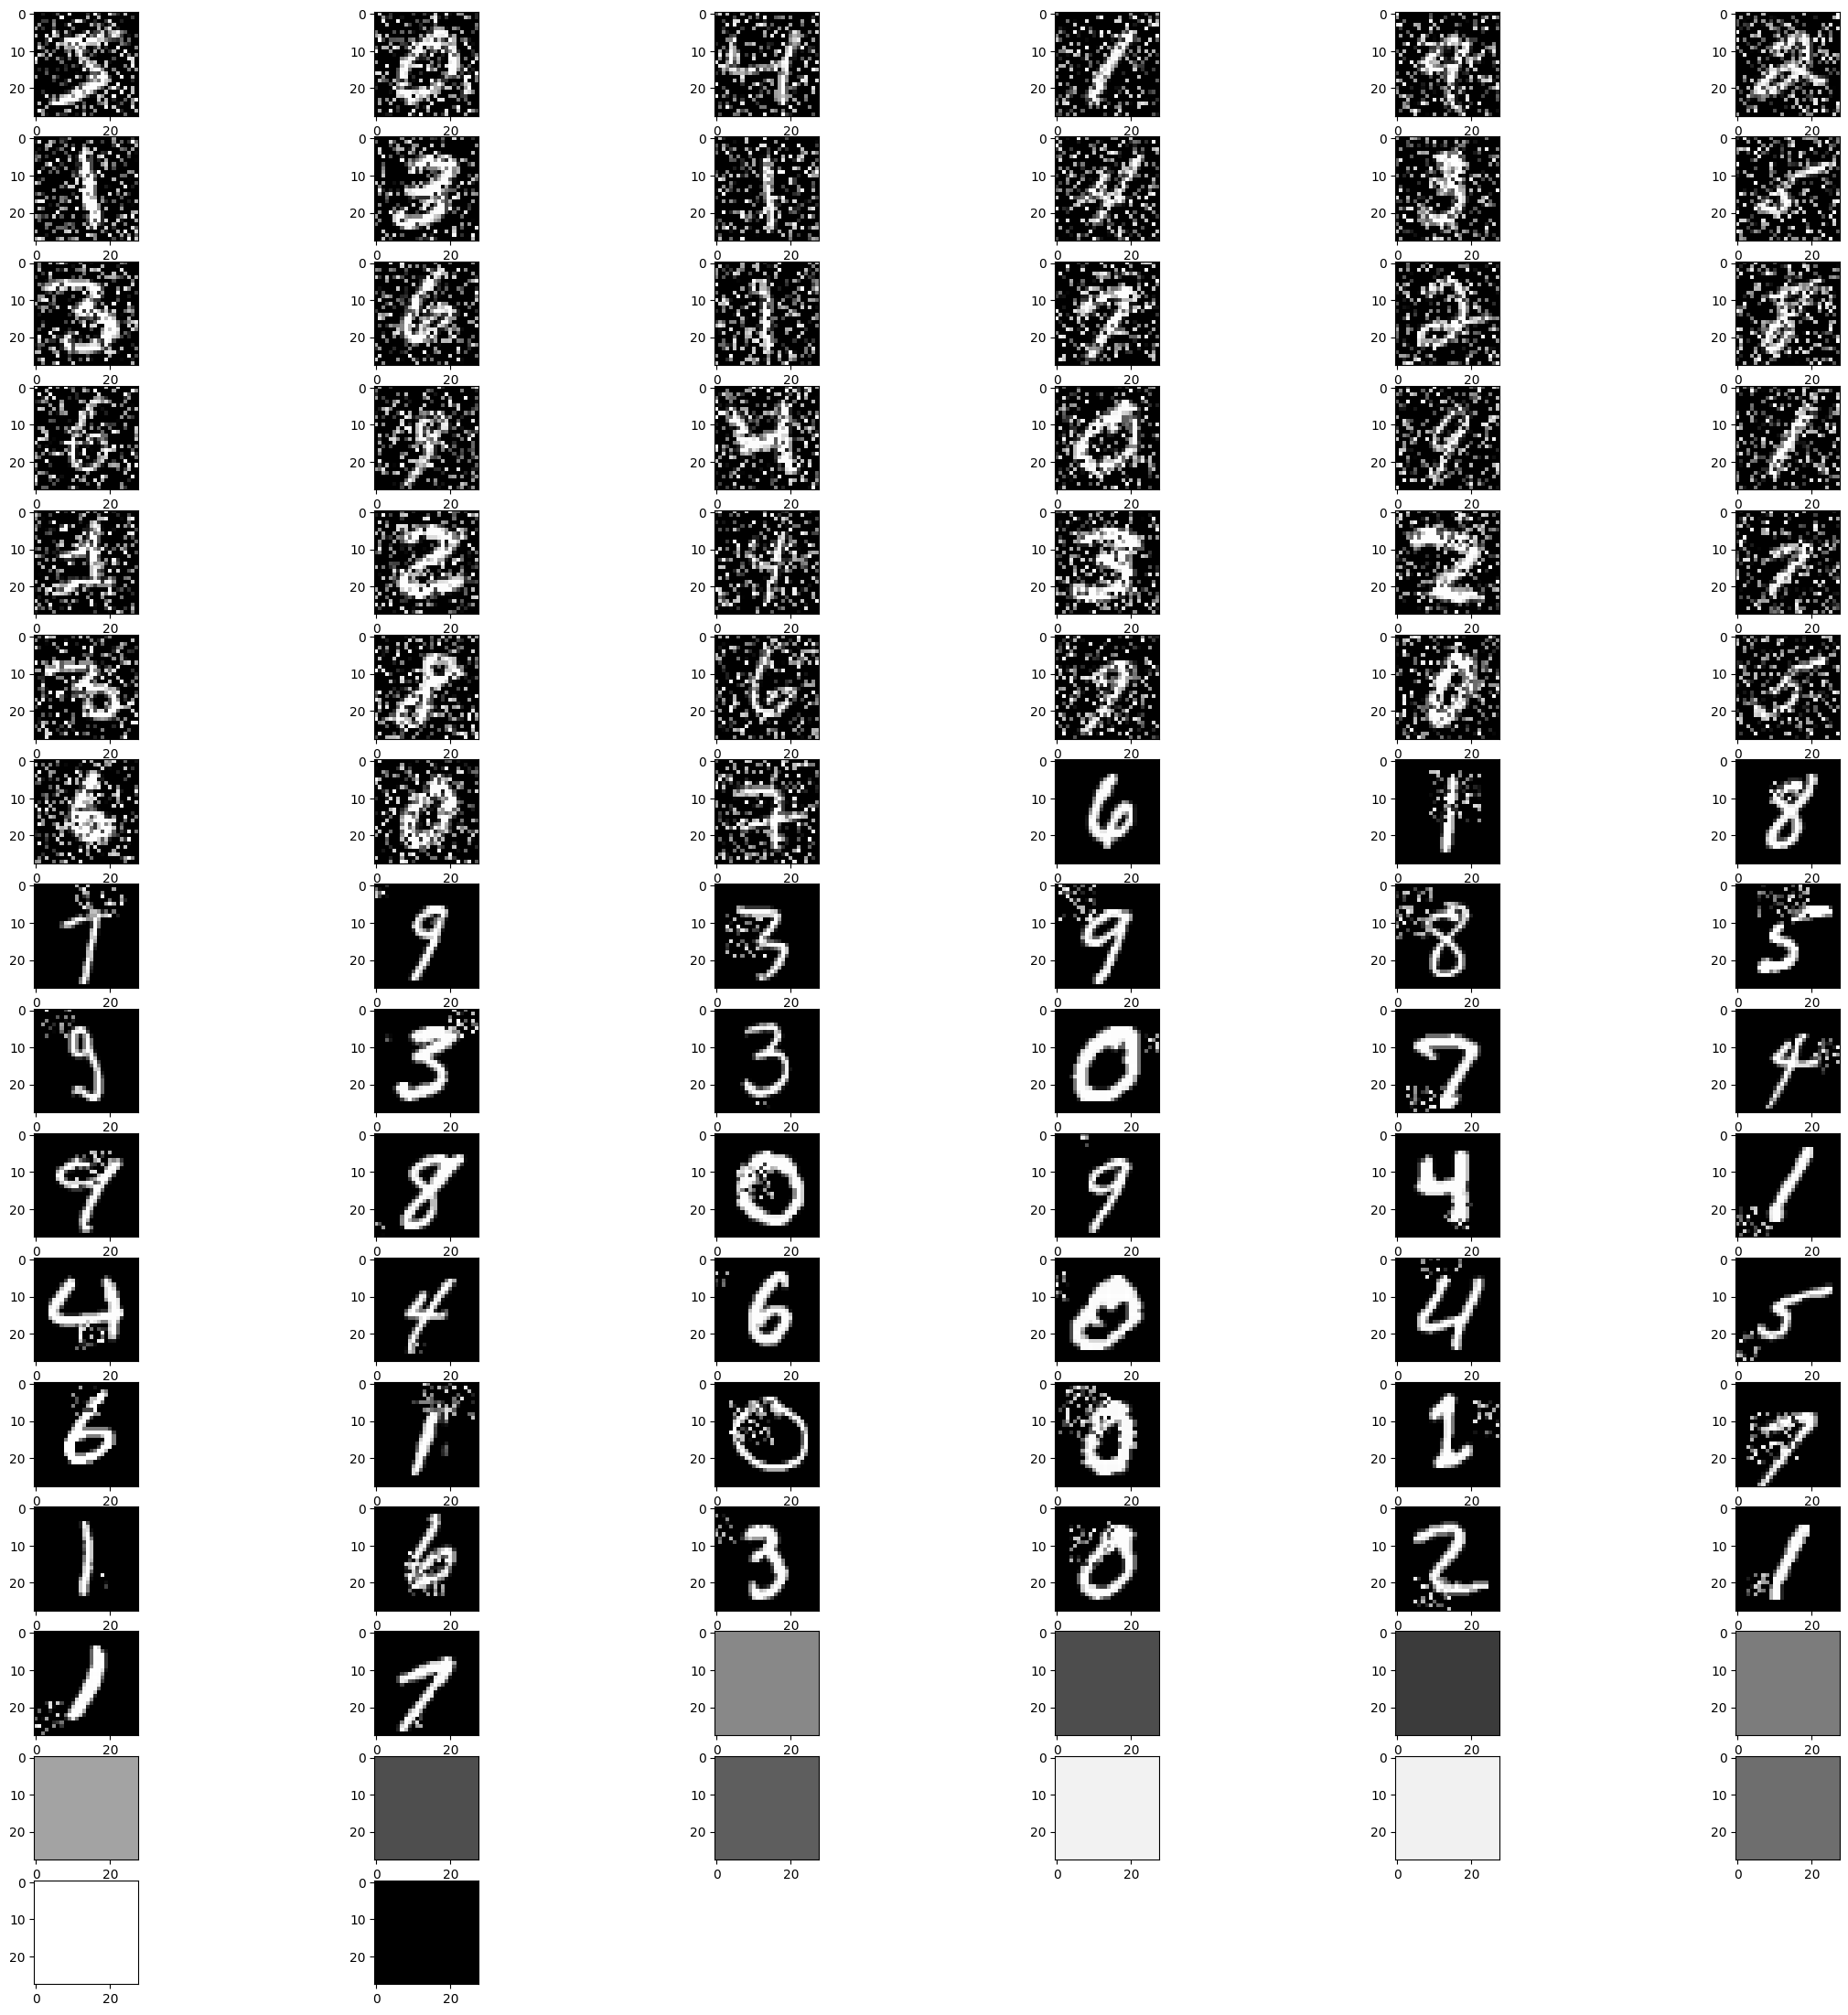

In [711]:
test_set_noise = X_train_noised[0:80].tolist().copy()
for iteration in range(10):
    test_set_noise.append([random.randint(0, 255)] * 784)
    
test_set_noise.append([255] * 784)
test_set_noise.append([0] * 784)

show_images_outliers(np.array(test_set_noise))

C:\Users\Alexey\AppData\Local\Temp\ipykernel_18584\11997394.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 6, 1 + i)


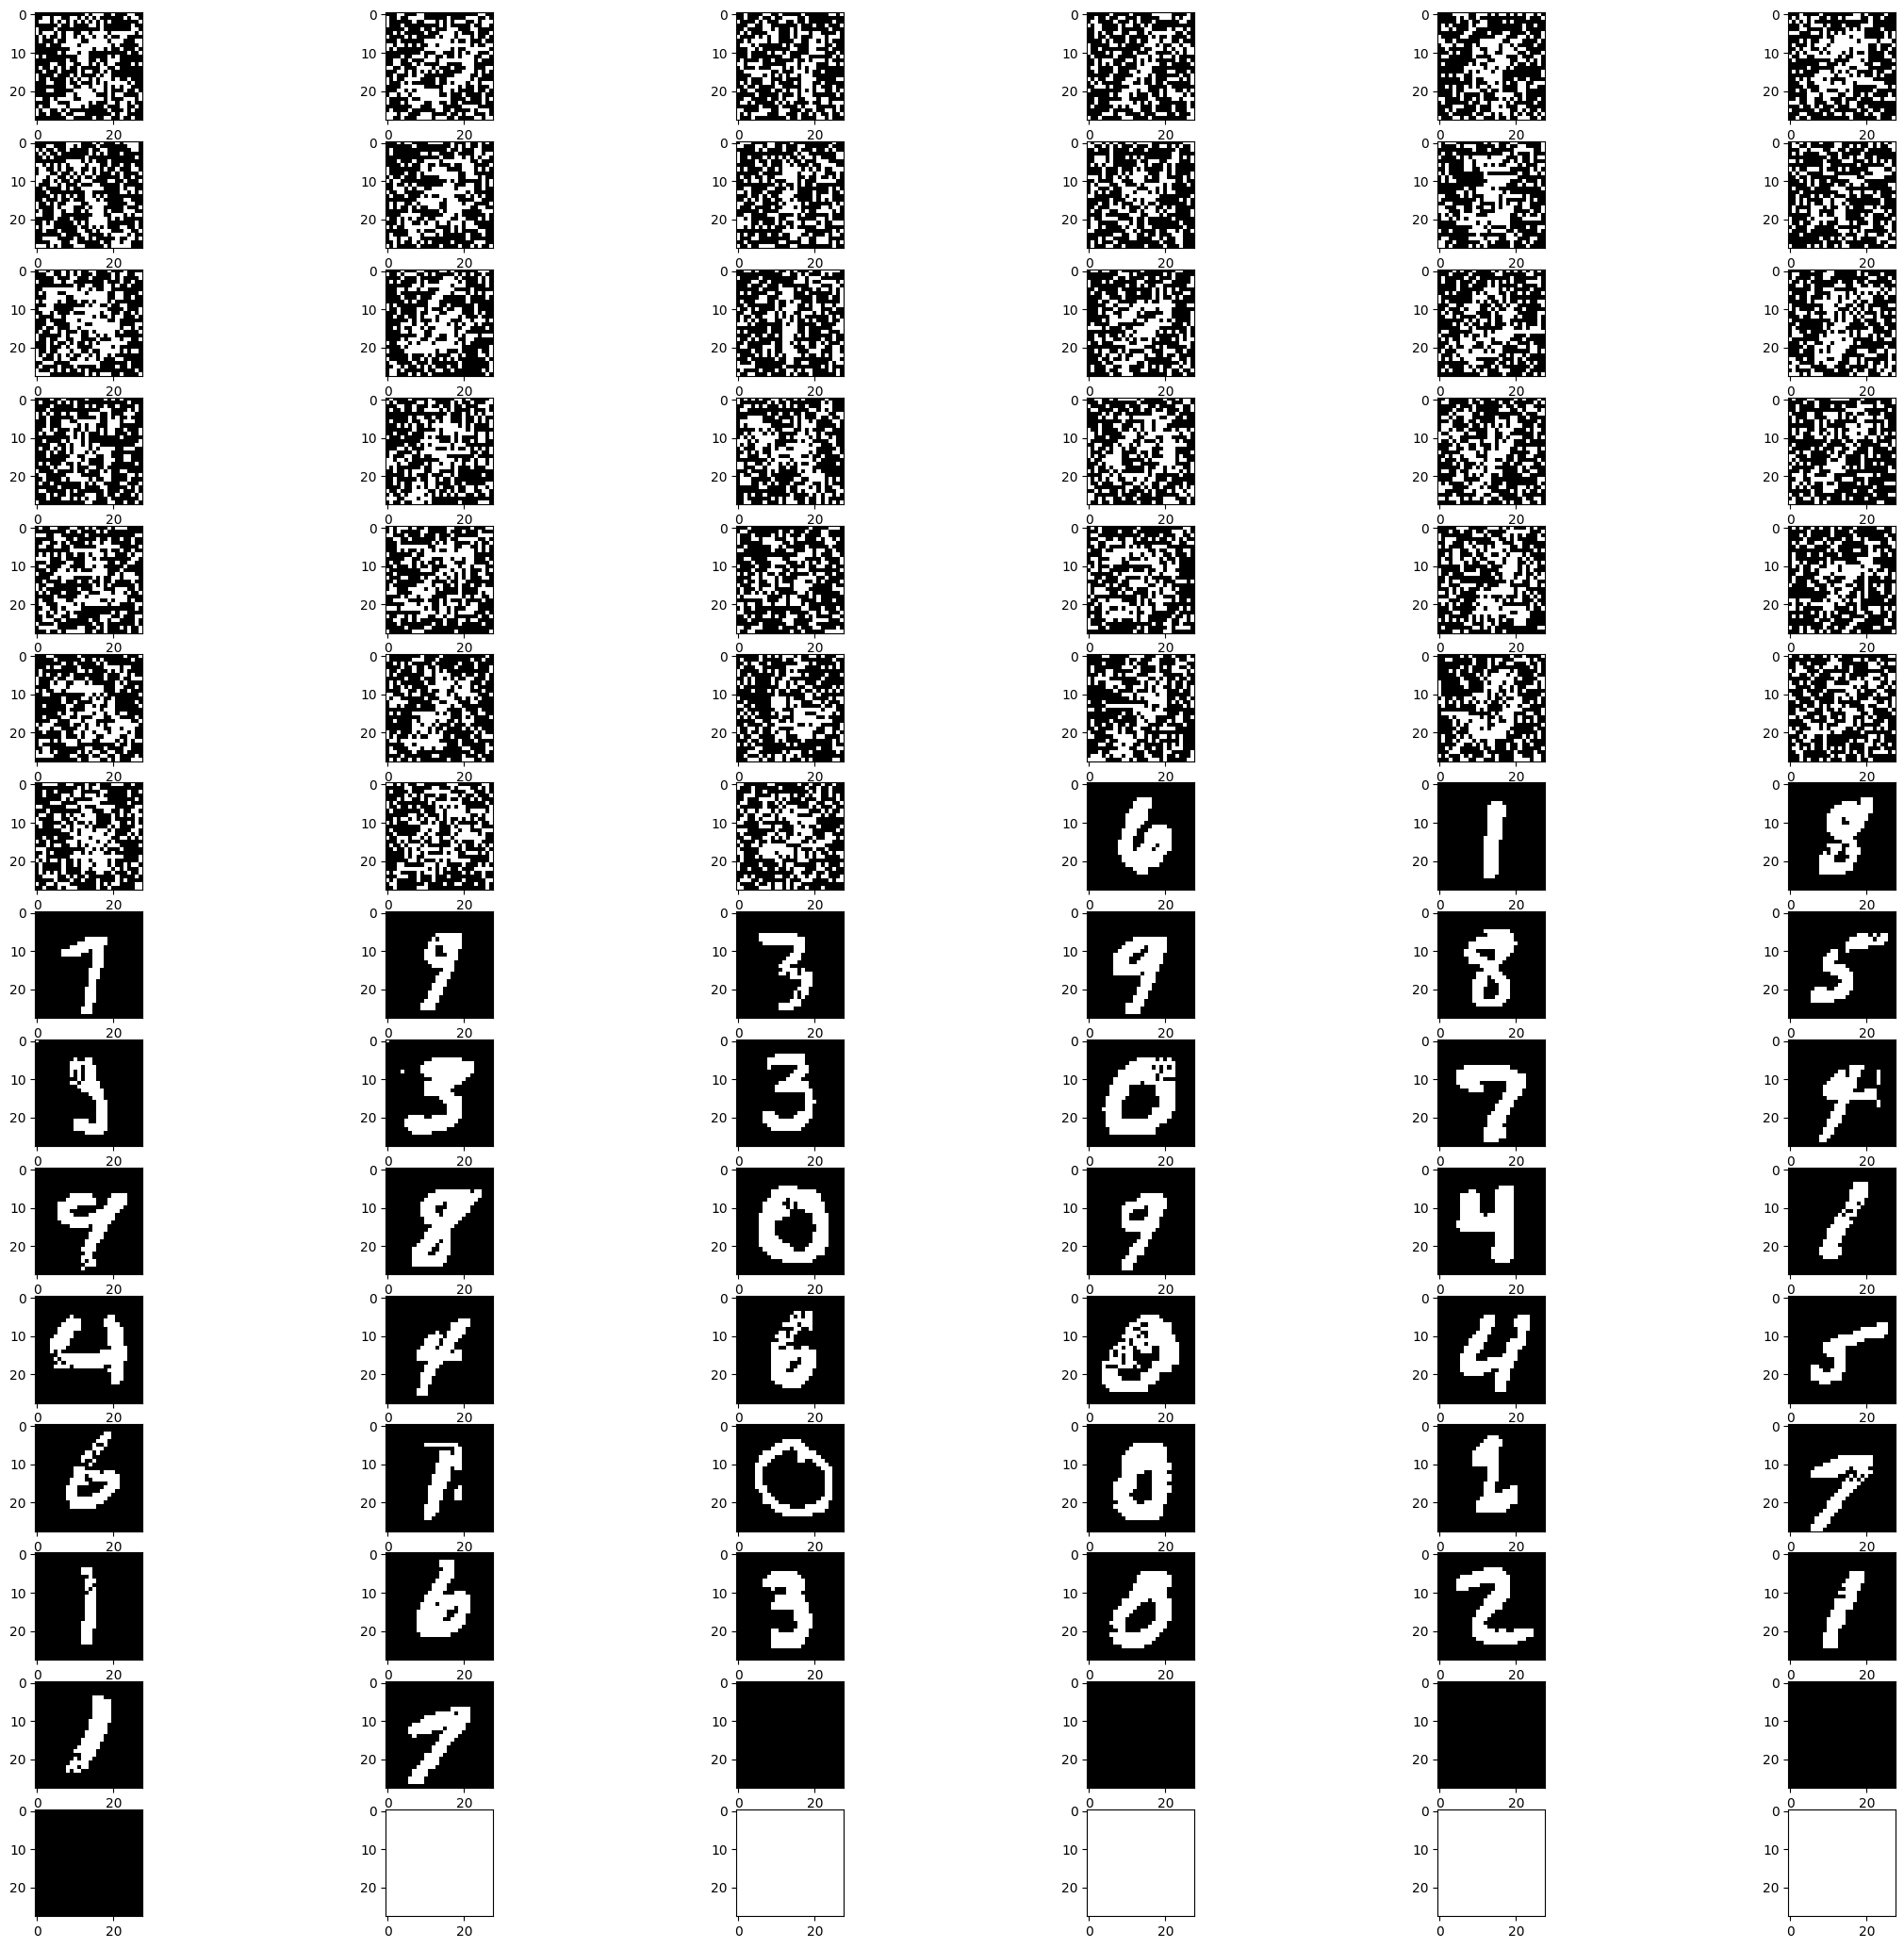

In [712]:
test_set_noise_bw = X_train_noised_bw[0:80].tolist().copy()

for iteration in range(5):
    test_set_noise_bw.append([0] * 784)
    
for iteration in range(5):
    test_set_noise_bw.append([255] * 784)
    
show_images_outliers_bw(np.array(test_set_noise_bw))

ODIN

In [713]:
outcasts = []
odin(test_set_noise, euc_dist, outcasts, 5, 35)

Число выбросов, определенных ODIN:88
Реально выбросов:92


C:\Users\Alexey\AppData\Local\Temp\ipykernel_18584\995382535.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 6, 1 + i)


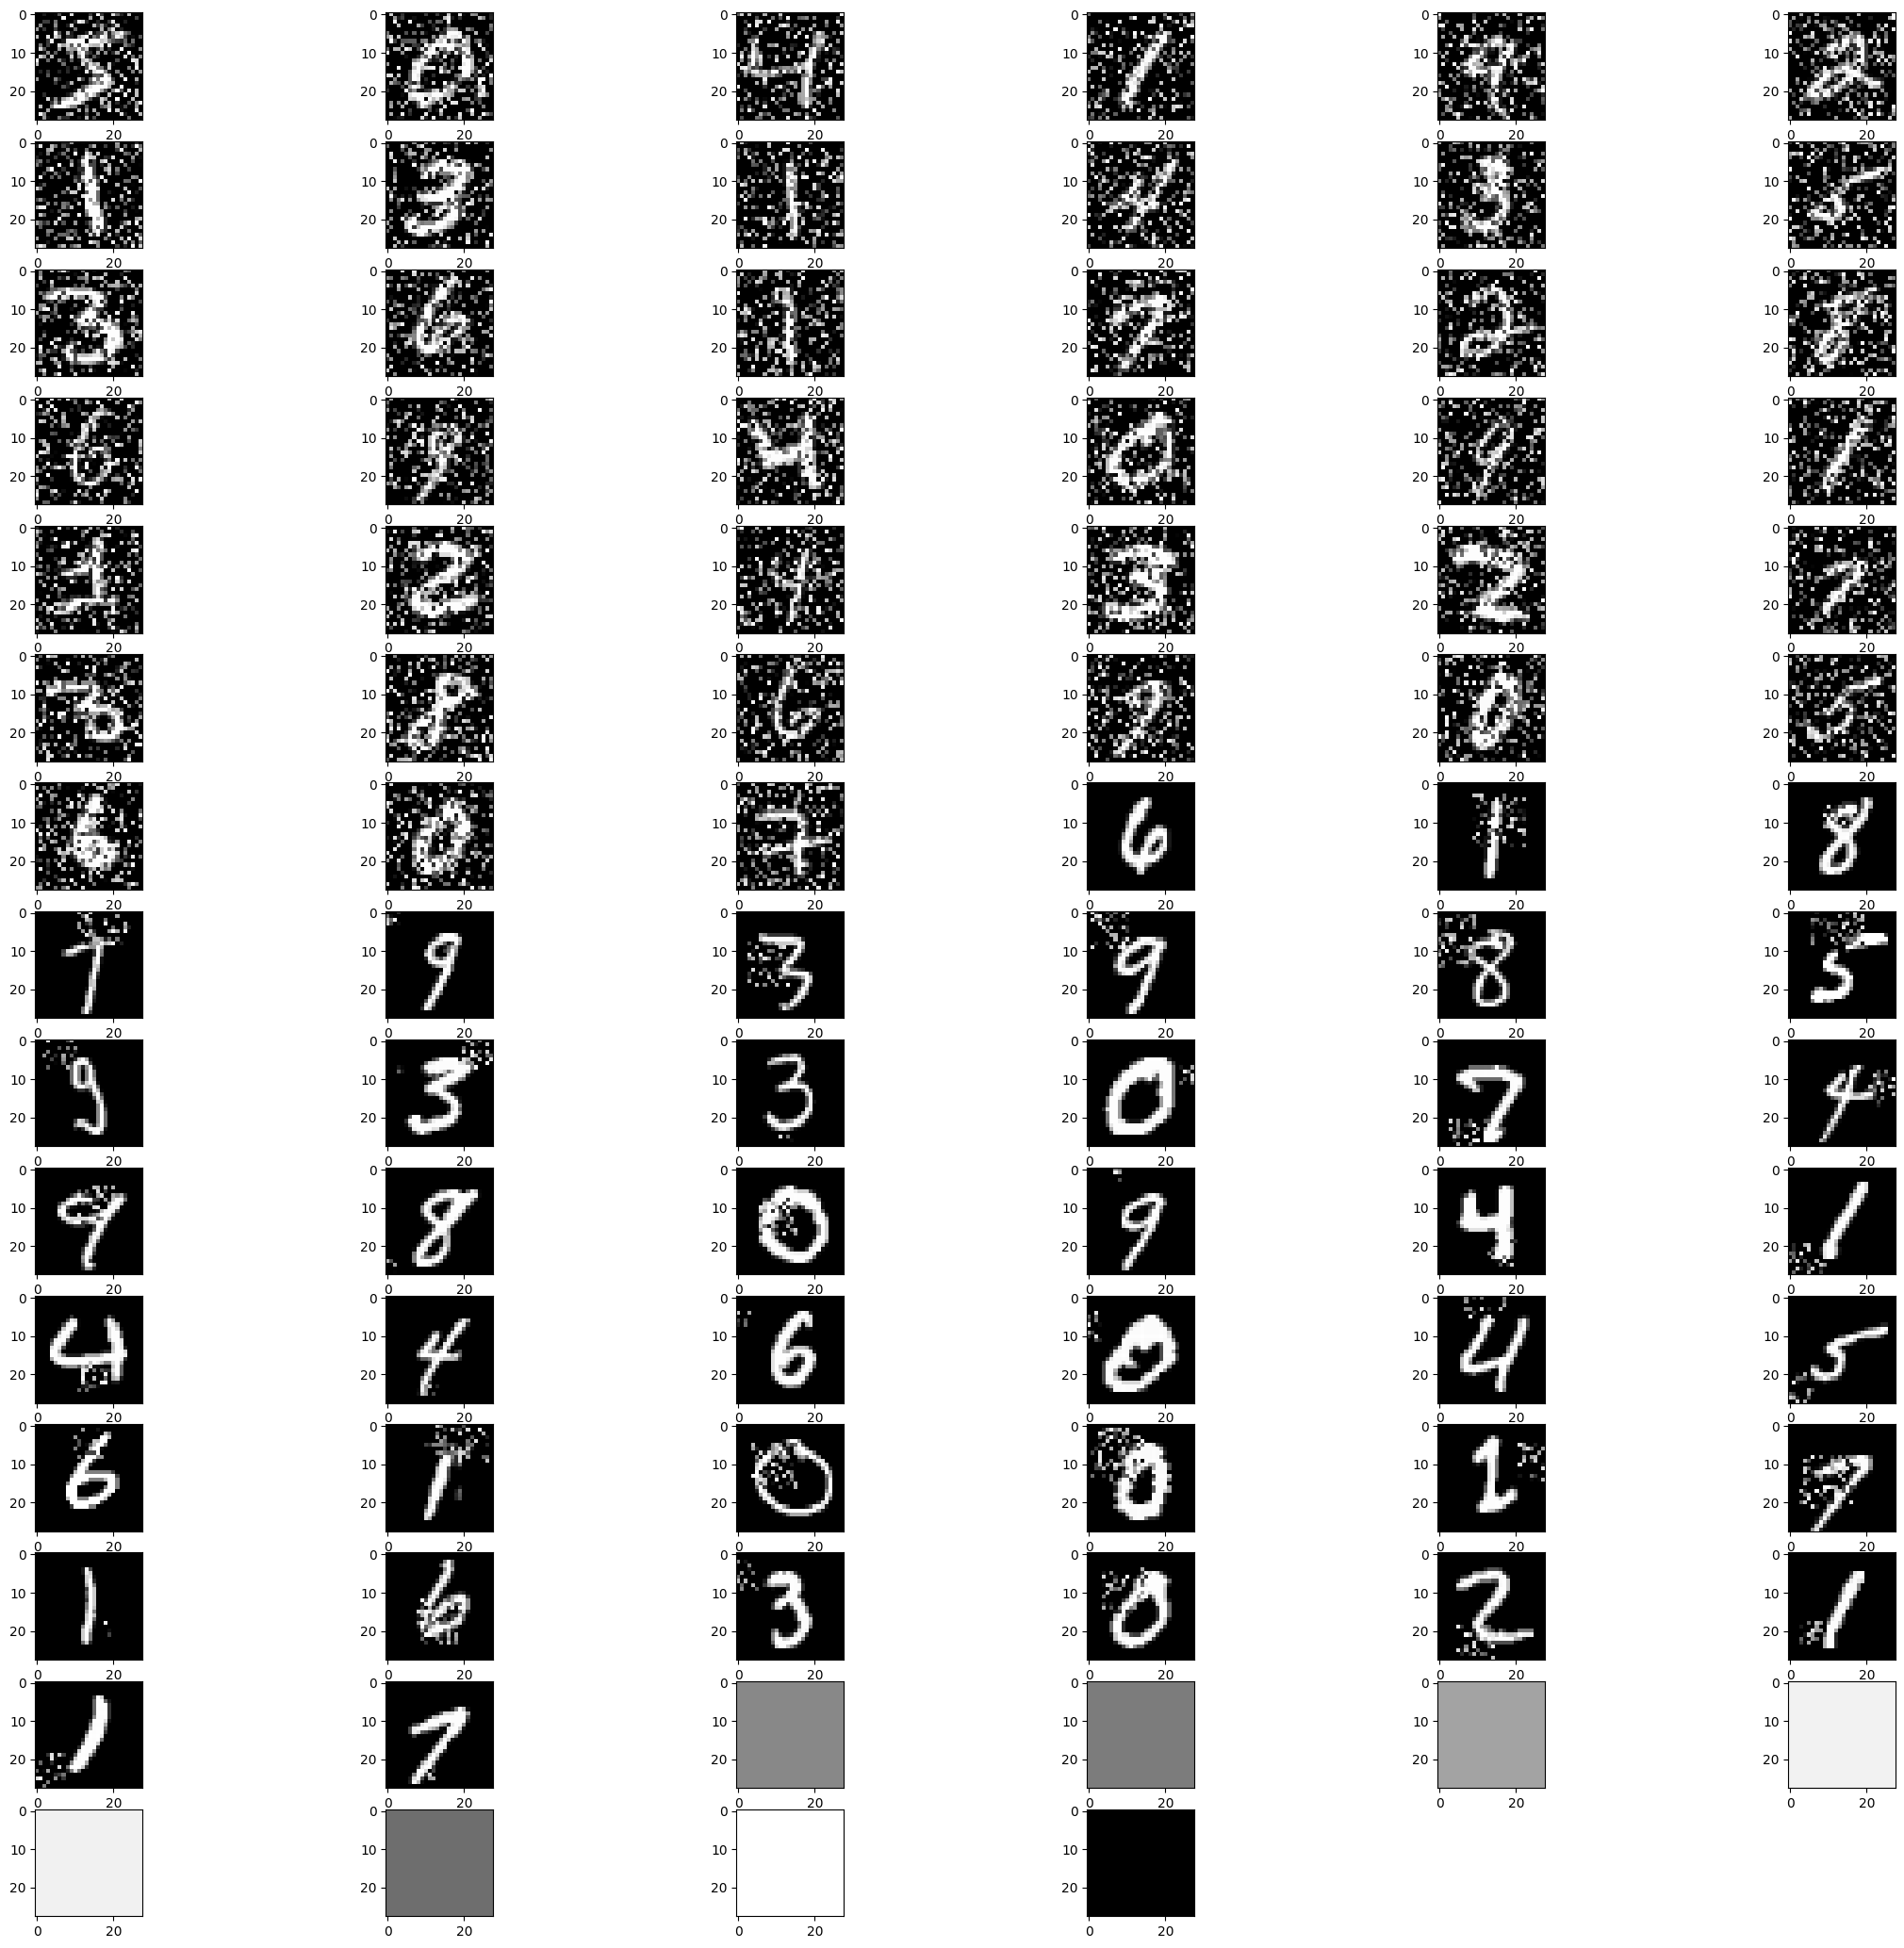

In [714]:
show_images_outliers(np.array(outcasts))

kNN

In [715]:
outcasts = []
knn(test_set_noise, euc_dist, outcasts, 20)

Среднее расстояние kNN при k = 20: 44.476269964507544
Число выбросов, определенных kNN:32
Реально выбросов:92


C:\Users\Alexey\AppData\Local\Temp\ipykernel_18584\995382535.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 6, 1 + i)


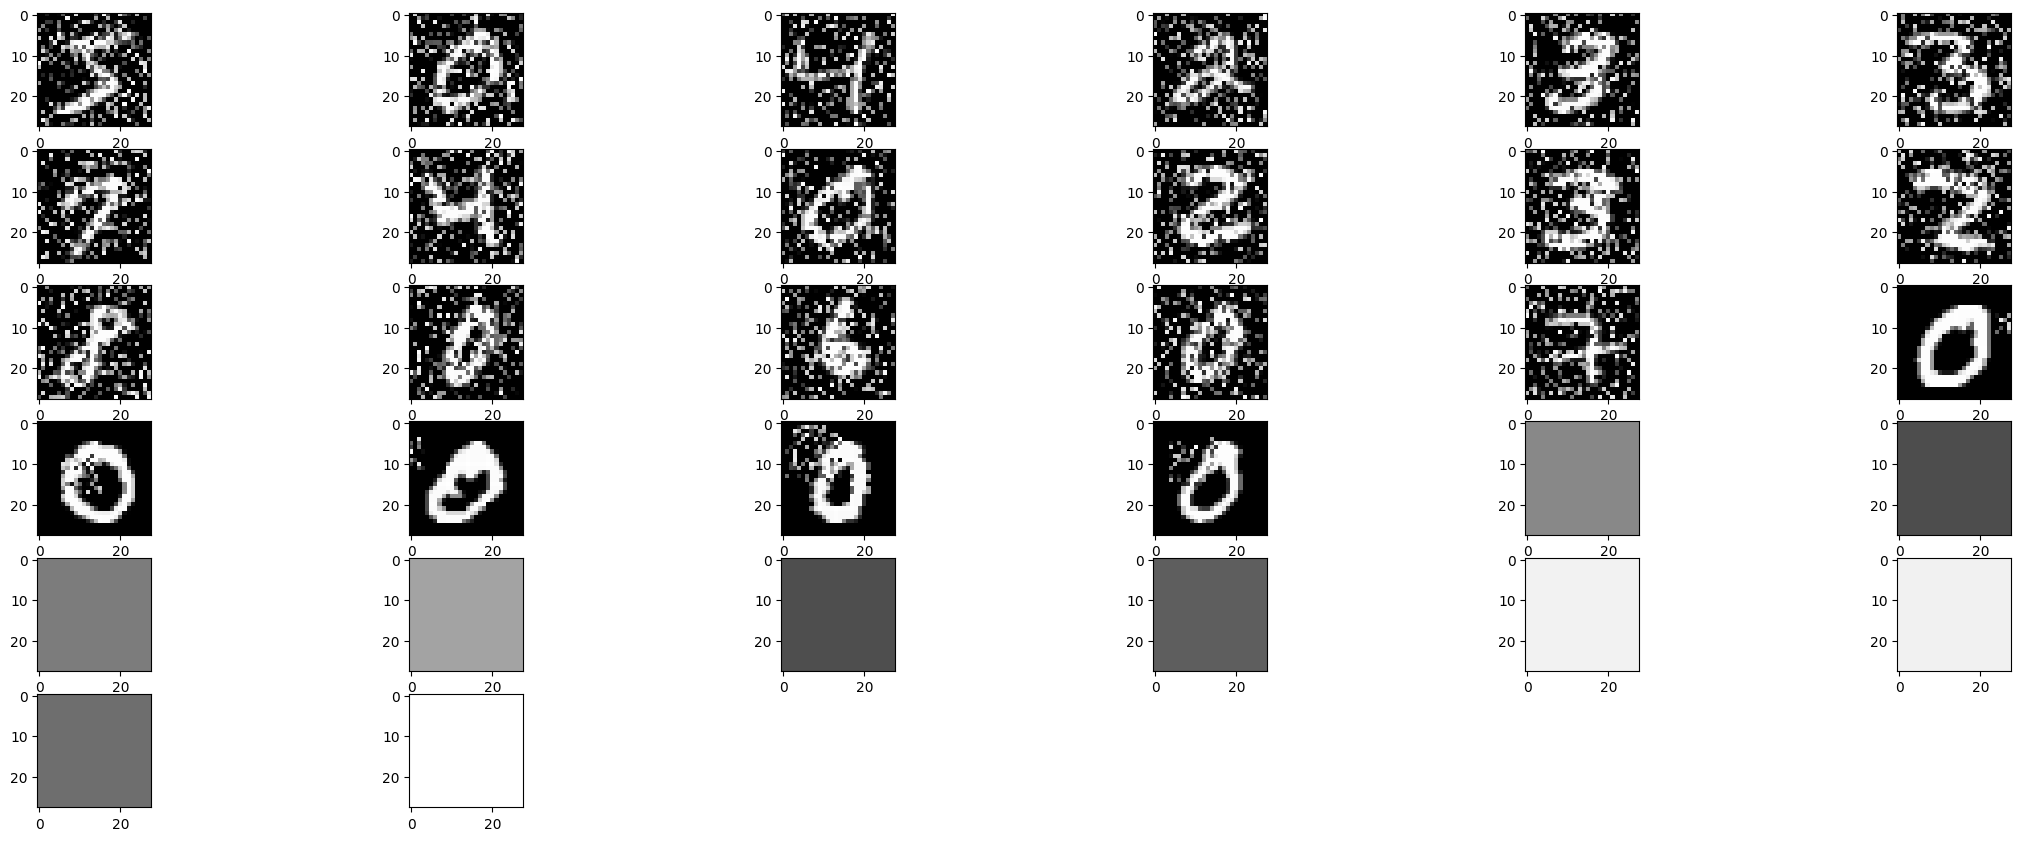

In [716]:
show_images_outliers(np.array(outcasts))

Ч\Б

ODIN

In [717]:
outcasts = []
odin(test_set_noise_bw, euc_dist, outcasts, 5, 35)

Число выбросов, определенных ODIN:85
Реально выбросов:90


C:\Users\Alexey\AppData\Local\Temp\ipykernel_18584\11997394.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 6, 1 + i)


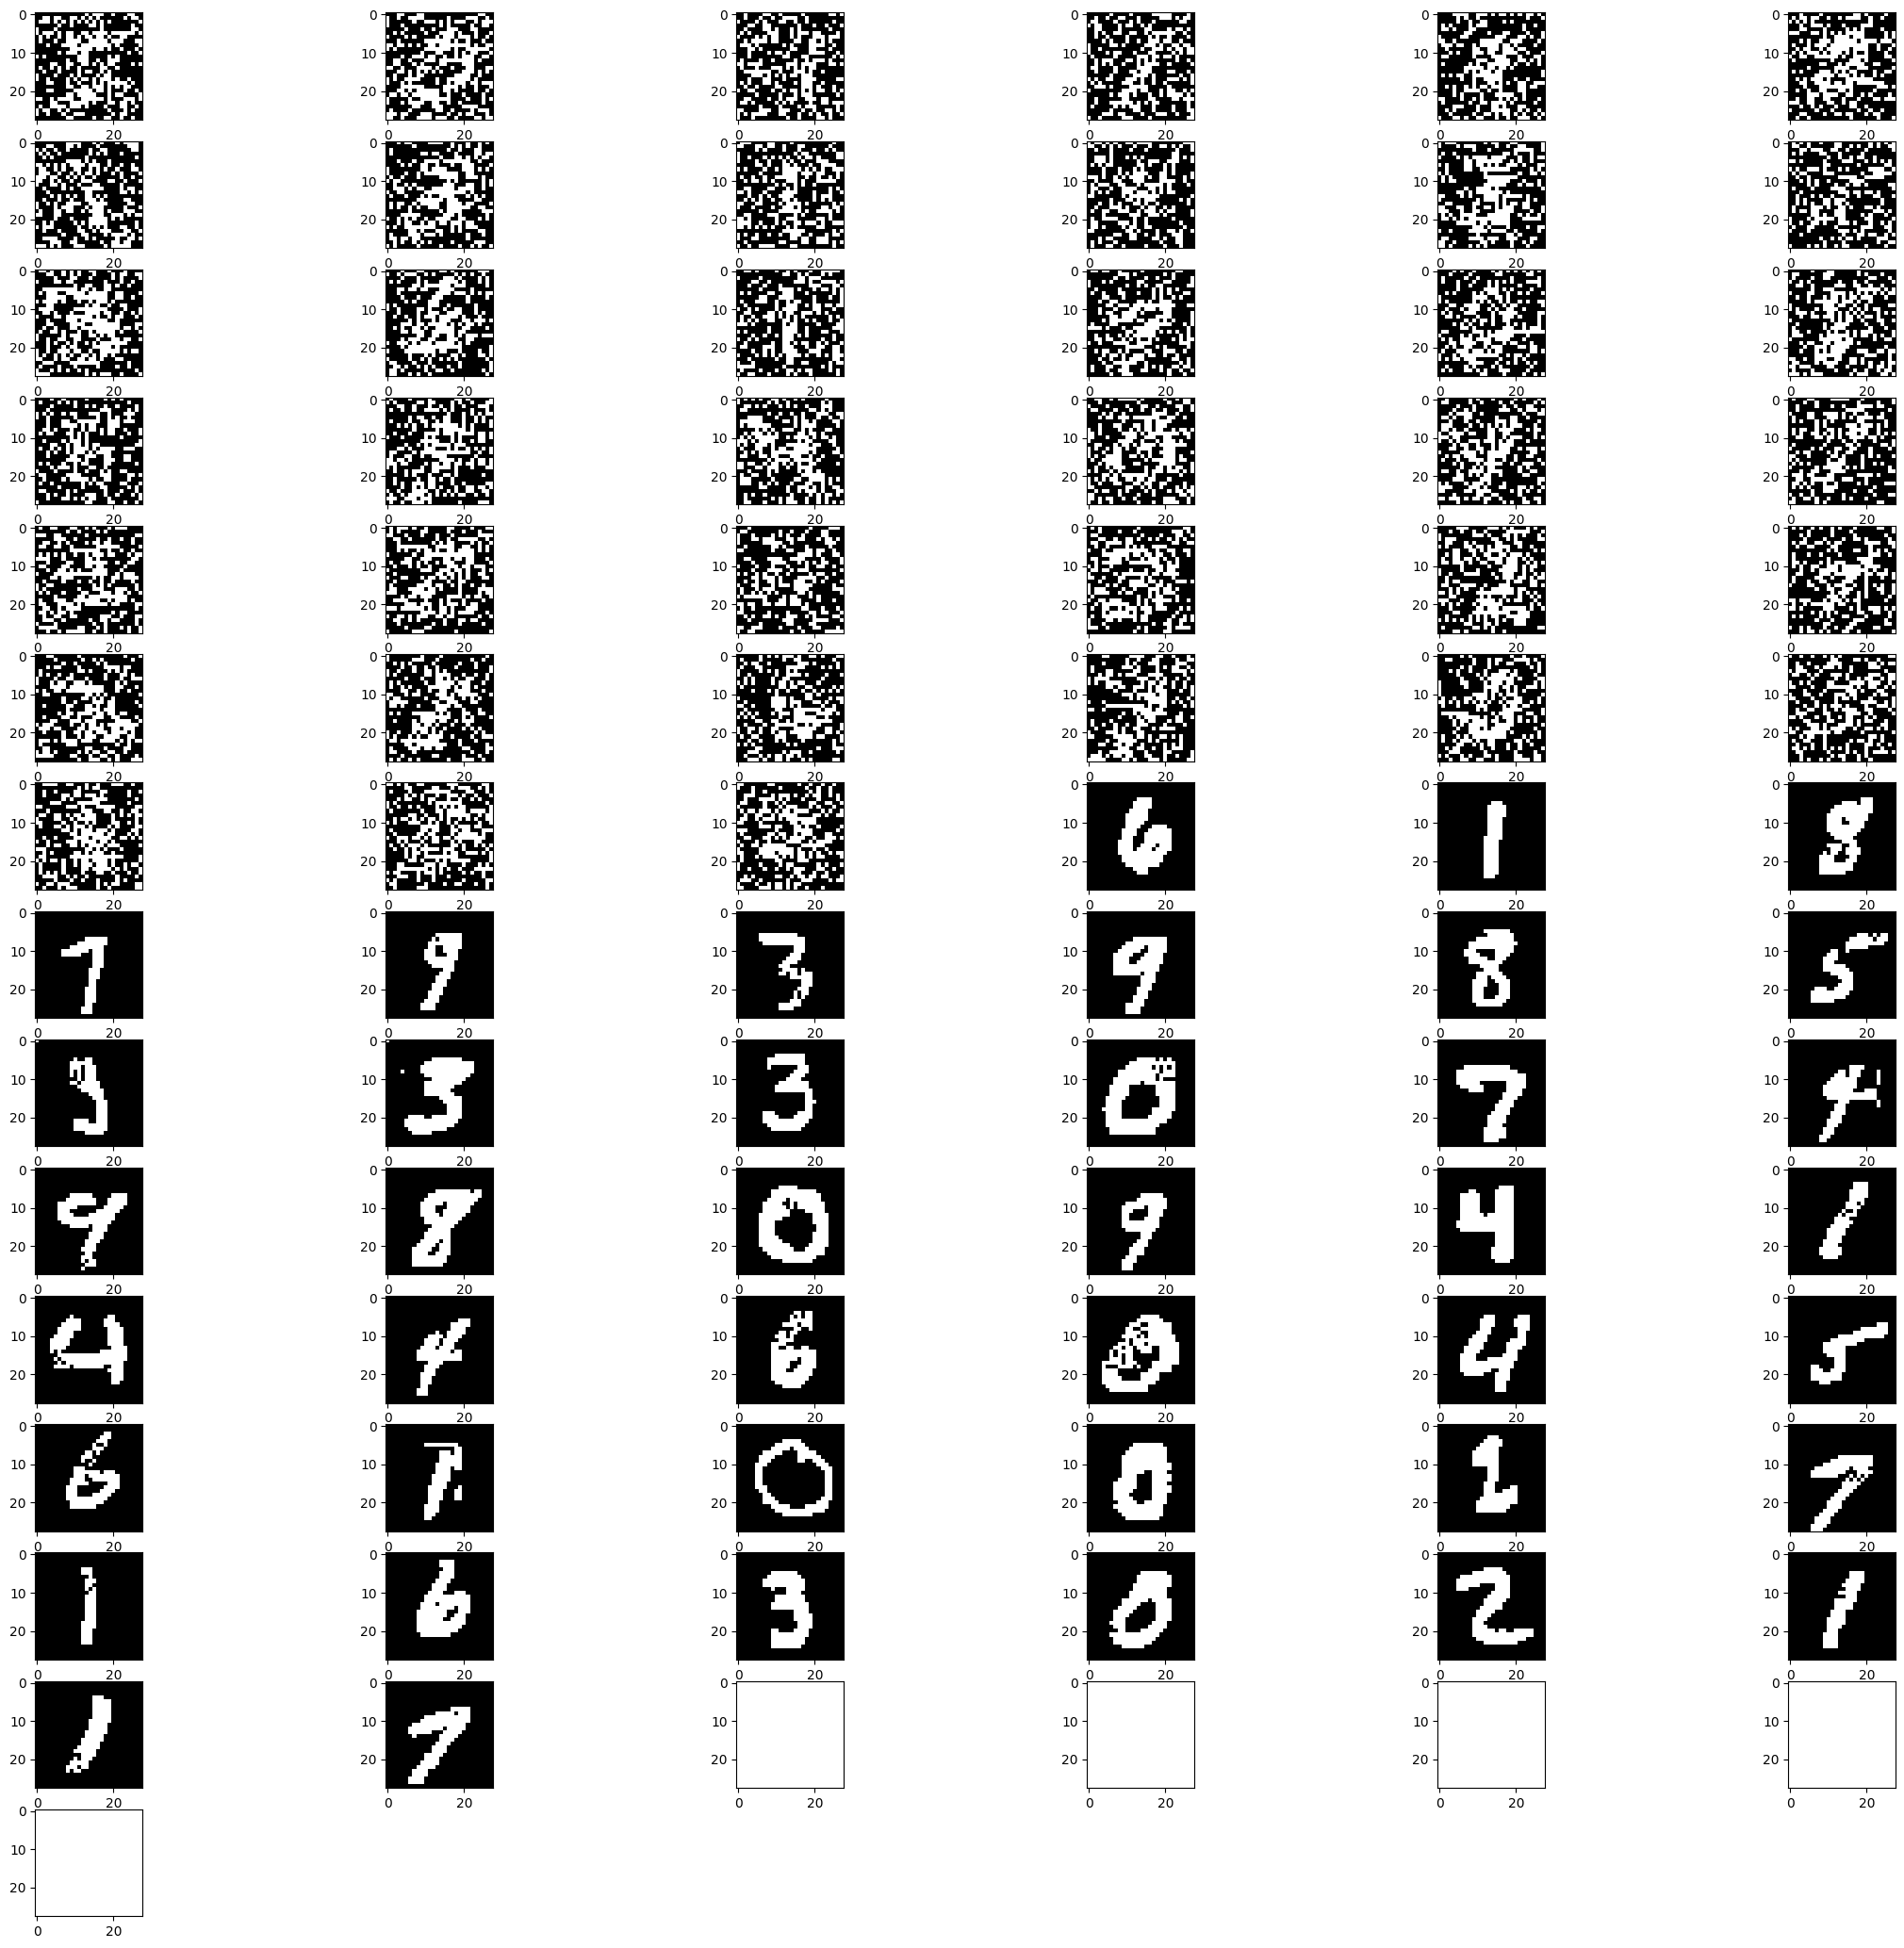

In [718]:
show_images_outliers_bw(np.array(outcasts))

kNN

In [719]:
outcasts = []
knn(test_set_noise_bw, euc_dist, outcasts, 20)

Среднее расстояние kNN при k = 20: 2.9805413832199545
Число выбросов, определенных kNN:5
Реально выбросов:90


C:\Users\Alexey\AppData\Local\Temp\ipykernel_18584\11997394.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  pyplot.subplot(16, 6, 1 + i)


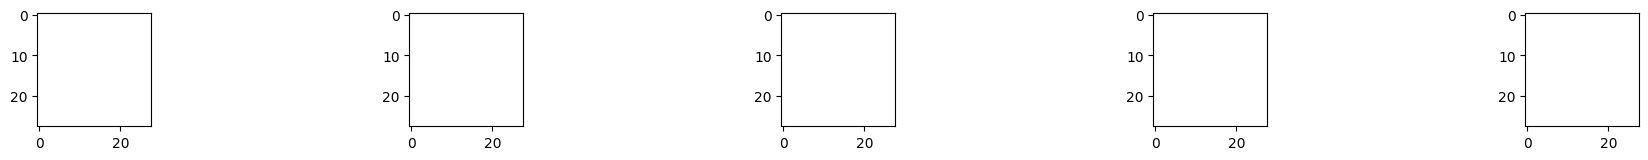

In [720]:
show_images_outliers_bw(np.array(outcasts))